# Import Libraries, Playlists, and Features

In [20]:
import pandas as pd
import numpy as np
import math
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_curve, auc, precision_score, ConfusionMatrixDisplay, roc_auc_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import time
import random
import os
import matplotlib.pyplot as plt
import plotly.express as px
import sweetviz as sv
from sklearn.decomposition import PCA
import pickle
import warnings

Spotify_Recommendations = pd.read_csv("SP_Recommendations_Artists_Tracks.csv")
Features_Sim_Art = pd.read_csv("Features_Using_Sim_Art.csv")
Features_SP_Rec = pd.read_csv("Features_Using_SP_Rec.csv")

plt.style.use('ggplot')


In [2]:
client_id = os.environ['SPOTIFY_CLIENT_ID']
secret = os.environ['SPOTIFY_SECRET']
username = os.environ['SPOTIFY_USERNAME']

In [3]:
scope = 'playlist-modify-private'

token = SpotifyOAuth(scope=scope, username=username, client_id=client_id, client_secret=secret, redirect_uri= "http://127.0.0.1:8080/")

sp = spotipy.Spotify(auth_manager=token)
sp.trace=False

In [4]:
# Playlist IDs for a list of playlists I like and dislike

good_playlist_list = ['6zwLst8kLfKazRv5D4B07m', '3zqf33EWGtjdKhRGvRRZlk', '1MrM9E65uDJ1O1KDnaKaMZ', 
                        '52IFraNVS2txBAHC6w27CS', '589IXCYLcJIEi1zykTKiDa', '3ZjXTgFmNw5XfnHqmLjolG',
                        '4vb0TPZRHAPrCt1Ccxixuz', '0k5KfueGF68BxzBN25QX3A', '1gQAw59fzdAHoSsRr3V3cy',
                        '4fPpuZqvH4i94Cqp33ry0y', '1J9BSsTPcKA55nQpCUuqRi', '3dIRjTC0Nenk1sDHSitwQv']


bad_playlist_list = ['6RT7wJWO5uxUIfhAMr1Jic']


In [32]:
# A way of extracting tracks from a playlist while avoiding the 100 track/playlist limit
# source: https://github.com/plamere/spotipy/issues/246 , slightly modified

def get_playlist_tracks(username, playlist_id):
    results = sp.user_playlist_tracks(username, playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks



def get_tracks(playlists):
    empty_list = []
    for i in playlists:

        playlist = get_playlist_tracks(client_id, i)

        for i, info in enumerate(playlist):
            x = playlist[i]
            track = x['track']['id']
            empty_list.append(track)
    return empty_list


In [17]:
def get_artists(track_list):
    artist_name_empty = []
    artist_id_empty = []
    for i in track_list:
        song = sp.track(i)
        artist_name = song['album']['artists'][0]['name']
        artist_id = song['album']['artists'][0]['id']
        artist_name_empty.append(artist_name)
        artist_id_empty.append(artist_id)
    
    artist_df = pd.DataFrame(columns=['name', 'id'])
    artist_df['name'] = artist_name_empty
    artist_df['id'] = artist_id_empty
    return artist_df


def artist_details(df):
    artist_popularity_empty = []
    artist_genre_empty = []
    track_id = []
    for i in df['id']:
        art = sp.artist(i)
        artist_pop = art['popularity']
        artist_genre = art['genres']
        artist_popularity_empty.append(artist_pop)
        artist_genre_empty.append(artist_genre)
        track_id.append(i)
    
    df['artist_popularity'] = artist_popularity_empty
    df['artist_genre'] = artist_genre_empty
    df['artist_track'] = track_id
    return df



In [18]:
# Getting the tracks and dropping duplicate IDs
good_list = list(set(get_tracks(good_playlist_list)))
bad_list = list(set(get_tracks(bad_playlist_list)))


print(len(good_list))
print(len(bad_list))

good_list_df = pd.DataFrame(good_list, columns=["song_id"])
good_list_df.to_csv("good_list.csv", index=False)

bad_list_df = pd.DataFrame(bad_list, columns=["song_id"])
bad_list_df.to_csv("bad_list.csv", index=False)

715
1171


In [19]:
good_artists = get_artists(good_list_df['song_id'])
good_artists_info = artist_details(good_artists)
good_artists_info['likable'] = 1

bad_artists = get_artists(bad_list_df['song_id'])
bad_artist_info = artist_details(bad_artists)
bad_artist_info['likable'] = 0

artist_list = [good_artists_info, bad_artist_info]
artist_df = pd.concat(artist_list)

In [20]:
artist_df.to_csv("good_bad_artists.csv", index=False)

In [4]:
artist_df_import = pd.read_csv("good_bad_artists.csv")

# Data Cleaning and EDA

In [88]:
# Adding track features for analysis.
# A sleep timer was added to (hopefully) avoid API call limits.
# The actual rate limit is unspecified, 
# but it involves evaluating the 30 second moving average call rate

def add_features(track_list):

    empty_df = pd.DataFrame()
    count = 0

    for track in track_list:
        features = sp.audio_features(track)
        test_df = pd.DataFrame(features)
        empty_df = pd.concat([empty_df, test_df])
        count += 1
        if count%50 == 0:
            time.sleep(5)

            completed = empty_df.shape[0]
            remaining = len(track_list) - completed
            print("{} songs have been completed. {} songs remain.".format(completed, remaining))
            
            
    return empty_df


In [12]:
good_df = add_features(good_list)
bad_df = add_features(bad_list)


good_df['likable'] = 1
bad_df['likable'] = 0

print("The shape of the list of songs I like: {}".format(good_df.shape))
print("The shape of the list of songs I dislike: {}".format(bad_df.shape))

# combining the dfs
x = [good_df, bad_df]

first_df = pd.concat(x)

# Duplicates of both lists were already dropped. The below function drops any duplicates
# which were in both playlists and keeping neither value.
first_df = first_df.drop_duplicates(keep=False)

50 songs have been completed. 662 songs remain.
100 songs have been completed. 612 songs remain.
150 songs have been completed. 562 songs remain.
200 songs have been completed. 512 songs remain.
250 songs have been completed. 462 songs remain.
300 songs have been completed. 412 songs remain.
350 songs have been completed. 362 songs remain.
400 songs have been completed. 312 songs remain.
450 songs have been completed. 262 songs remain.
500 songs have been completed. 212 songs remain.
550 songs have been completed. 162 songs remain.
600 songs have been completed. 112 songs remain.
650 songs have been completed. 62 songs remain.
700 songs have been completed. 12 songs remain.
50 songs have been completed. 1121 songs remain.
100 songs have been completed. 1071 songs remain.
150 songs have been completed. 1021 songs remain.
200 songs have been completed. 971 songs remain.
250 songs have been completed. 921 songs remain.
300 songs have been completed. 871 songs remain.
350 songs have been c

In [9]:
first_df.to_csv("Initial_Data_with_Features.csv", index=False)

NameError: name 'first_df' is not defined

In [38]:
# contains all of the features above, including the track ID
imported = pd.read_csv("Initial_Data_with_Features.csv")

In [91]:
imported.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,likable
0,0.558,0.304,2,-10.871,1,0.0347,0.739,0.000000,0.1170,0.195,127.502,audio_features,4o8ASl77G362BEVsp3TuvB,spotify:track:4o8ASl77G362BEVsp3TuvB,https://api.spotify.com/v1/tracks/4o8ASl77G362...,https://api.spotify.com/v1/audio-analysis/4o8A...,238133,4,1
1,0.623,0.962,4,-2.616,0,0.0895,0.103,0.000174,0.2640,0.676,149.963,audio_features,5PUawWFG1oIS2NwEcyHaCr,spotify:track:5PUawWFG1oIS2NwEcyHaCr,https://api.spotify.com/v1/tracks/5PUawWFG1oIS...,https://api.spotify.com/v1/audio-analysis/5PUa...,211573,4,1
2,0.558,0.889,8,-3.945,1,0.1020,0.191,0.000387,0.3280,0.716,170.102,audio_features,25ran9X0iBOYnxFdP6c28n,spotify:track:25ran9X0iBOYnxFdP6c28n,https://api.spotify.com/v1/tracks/25ran9X0iBOY...,https://api.spotify.com/v1/audio-analysis/25ra...,213547,4,1
3,0.834,0.531,3,-10.450,1,0.1600,0.480,0.000000,0.0957,0.390,99.999,audio_features,5erGUceK8ieHWtTXdnGP65,spotify:track:5erGUceK8ieHWtTXdnGP65,https://api.spotify.com/v1/tracks/5erGUceK8ieH...,https://api.spotify.com/v1/audio-analysis/5erG...,239612,4,1
4,0.399,0.318,10,-13.482,1,0.0295,0.892,0.012500,0.1190,0.383,93.566,audio_features,26bCI2KTzz0ow6kL6FEl5Z,spotify:track:26bCI2KTzz0ow6kL6FEl5Z,https://api.spotify.com/v1/tracks/26bCI2KTzz0o...,https://api.spotify.com/v1/audio-analysis/26bC...,268264,4,1


In [39]:
# Useless identification features are dropped
df = imported.copy()
cols_to_drop = ['type', 'uri', 'track_href', 'analysis_url']
df = df.drop(cols_to_drop, axis=1)

In [40]:
df.dtypes

danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
id                   object
duration_ms           int64
time_signature        int64
likable               int64
dtype: object

In [41]:
df.nunique()

danceability         613
energy               702
key                   12
loudness            1705
mode                   2
speechiness          728
acousticness        1322
instrumentalness    1101
liveness             688
valence              810
tempo               1823
id                  1880
duration_ms         1804
time_signature         4
likable                2
dtype: int64

                                             |          | [  0%]   00:00 -> (? left)


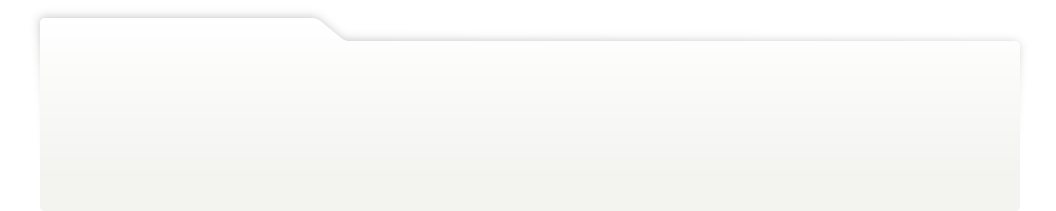
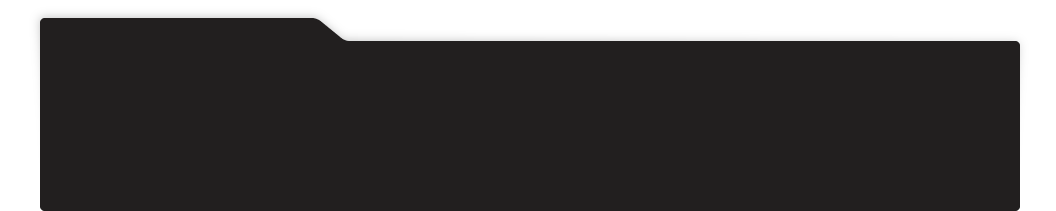
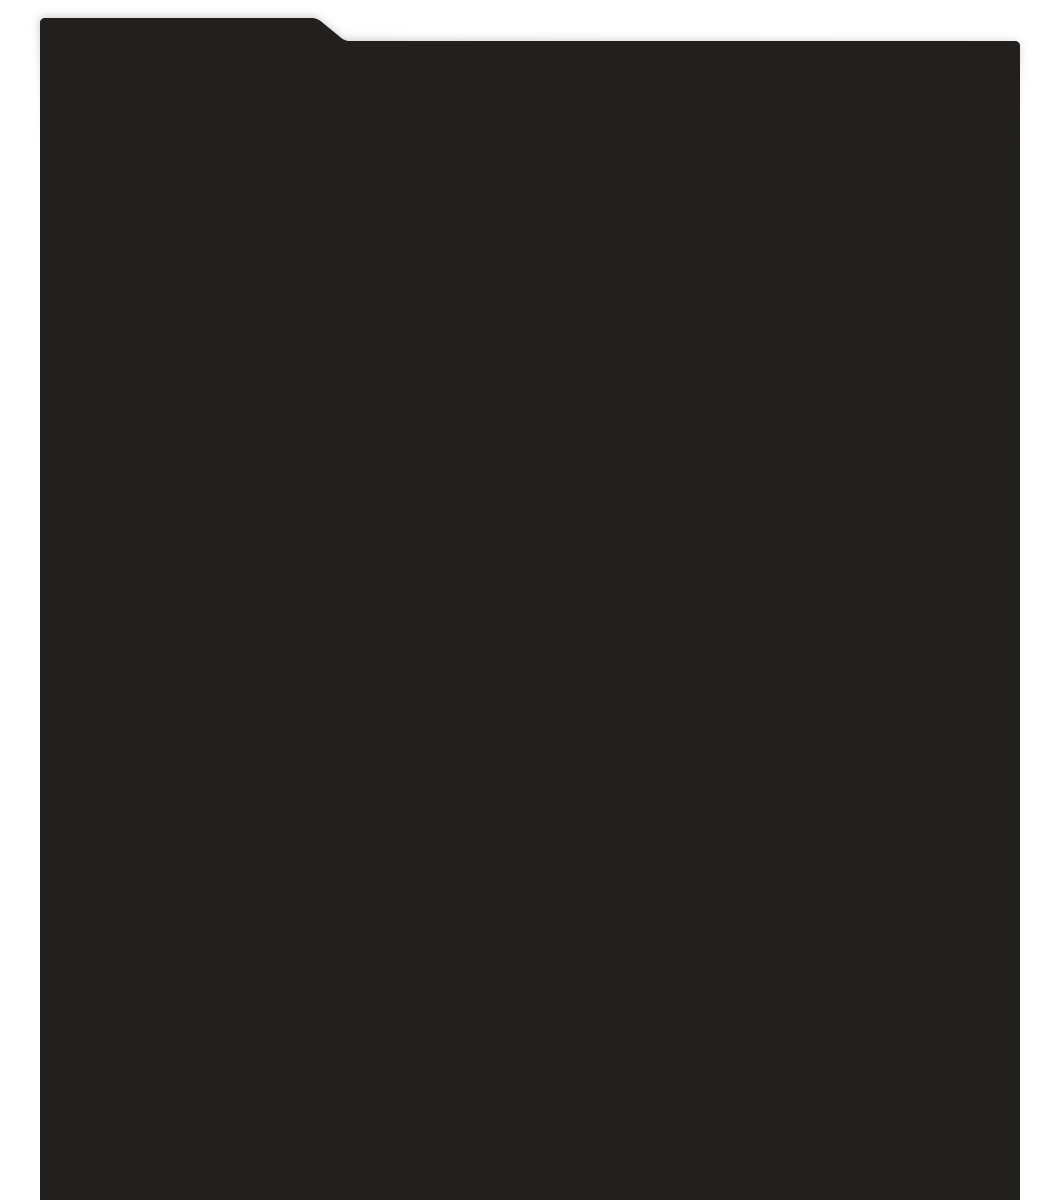
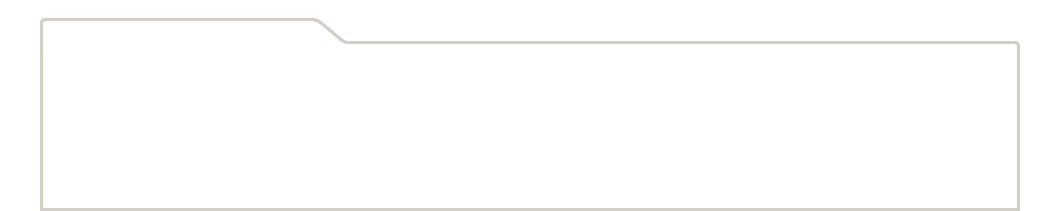
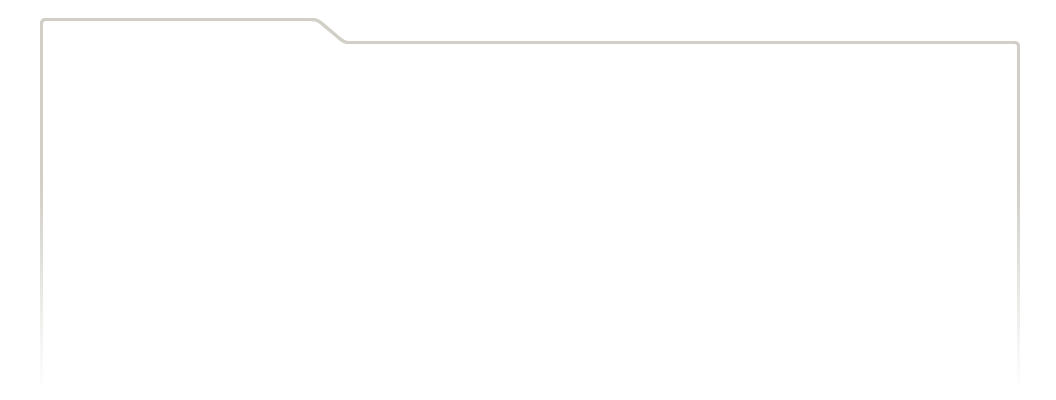
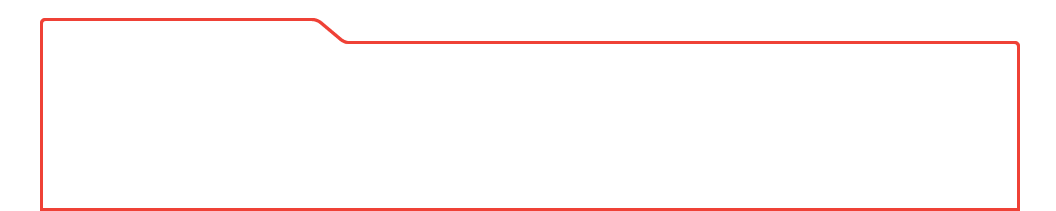
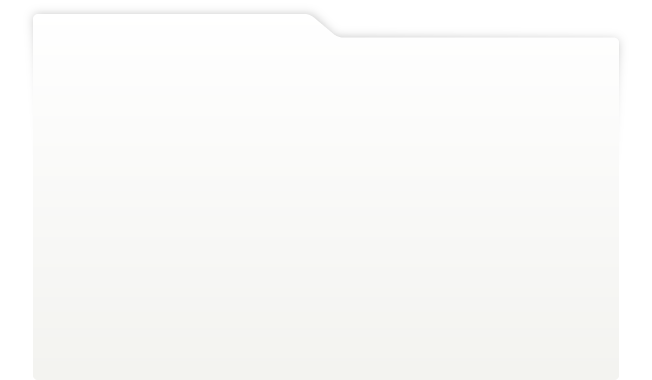
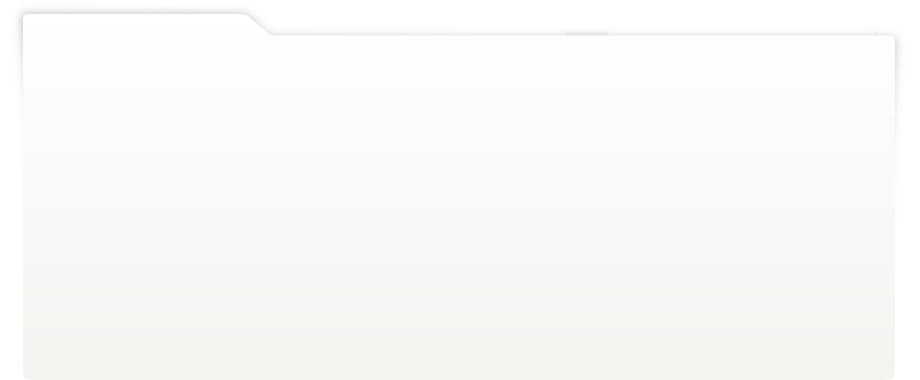
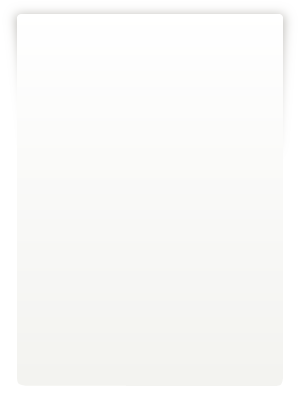
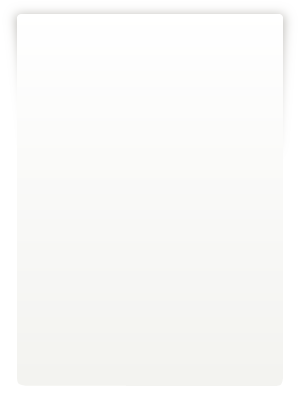
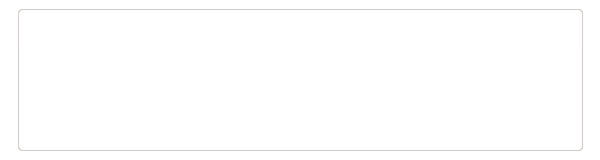
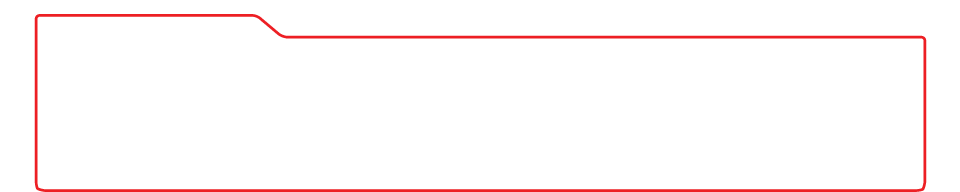
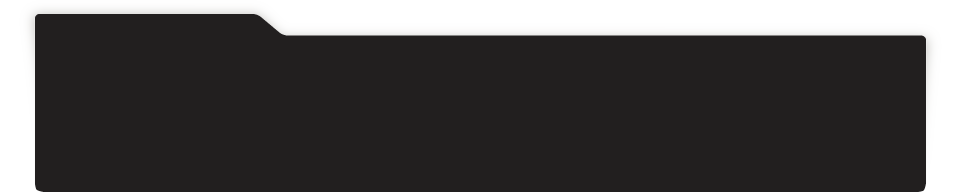
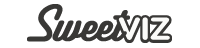
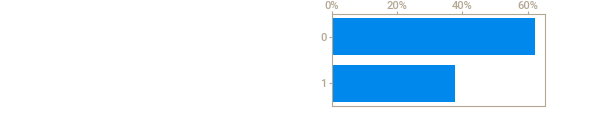
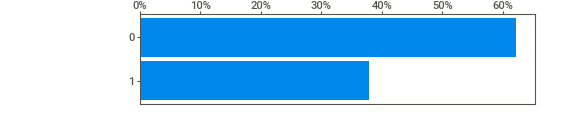
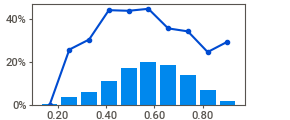
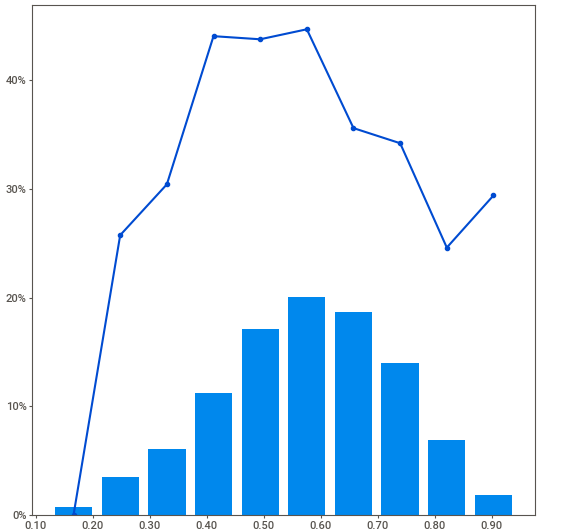
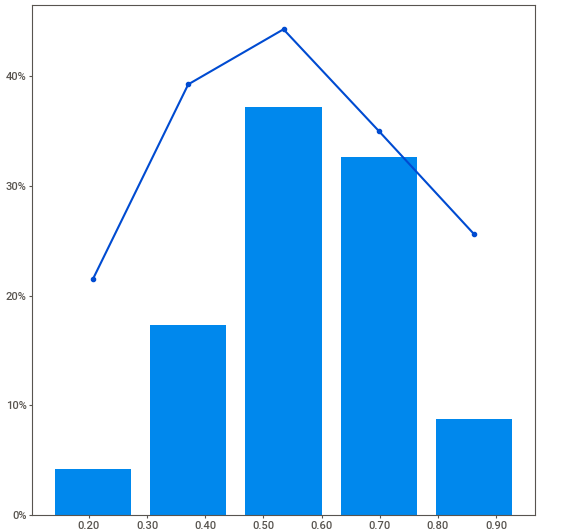
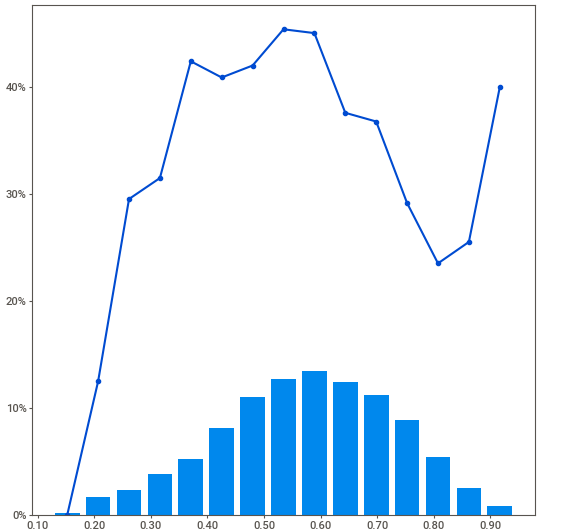
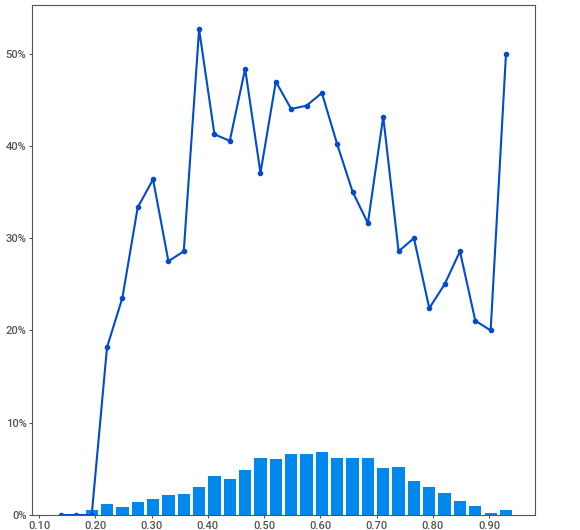
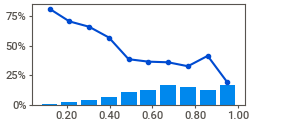
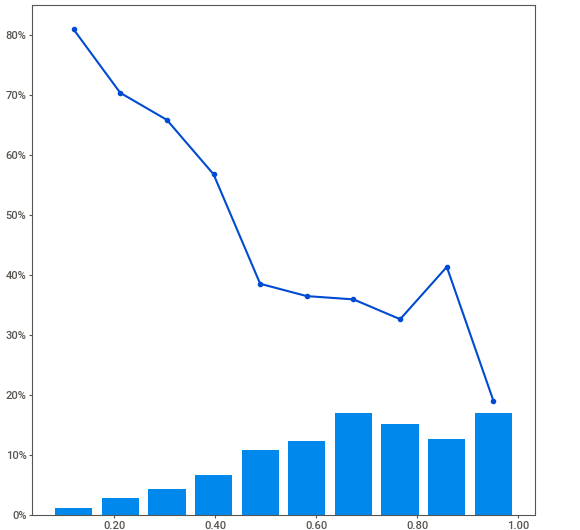
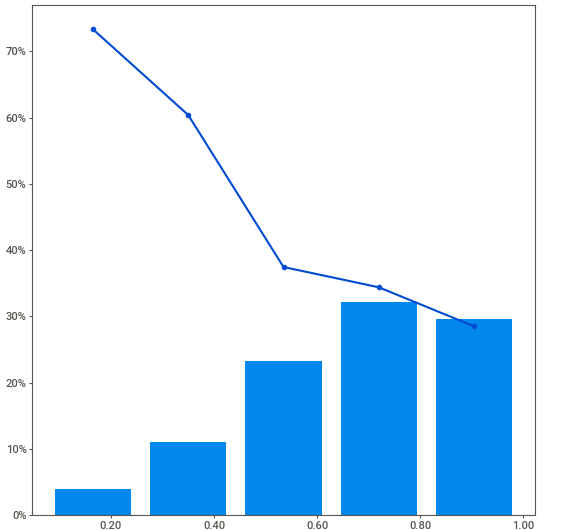
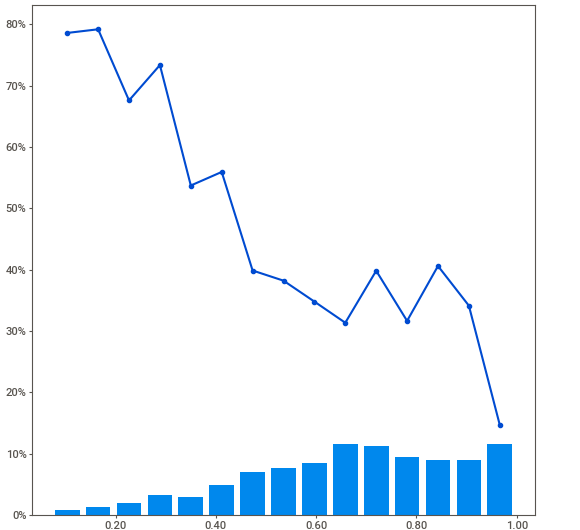
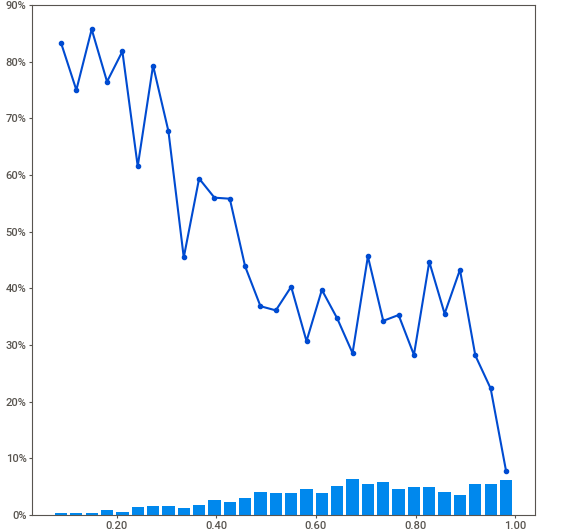
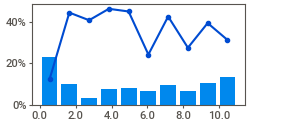
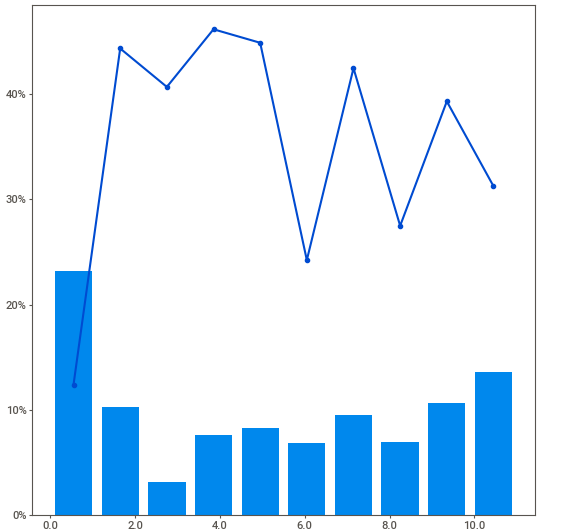
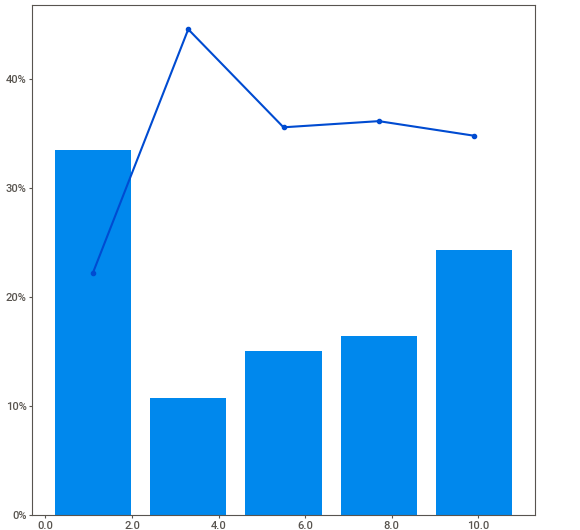
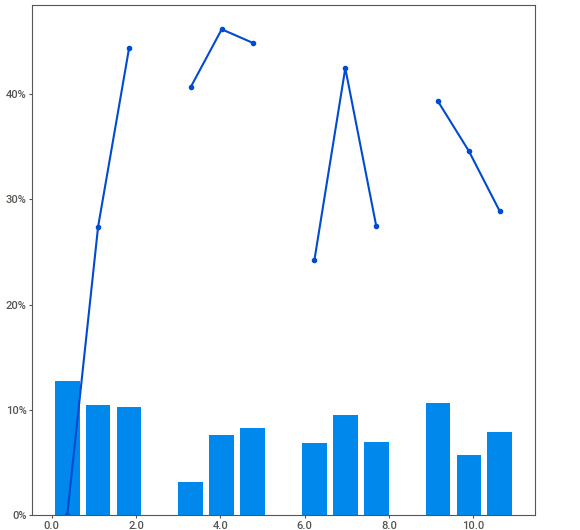
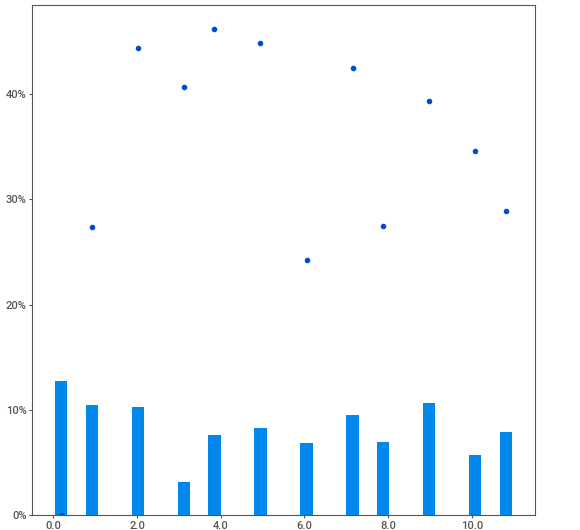
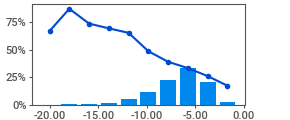
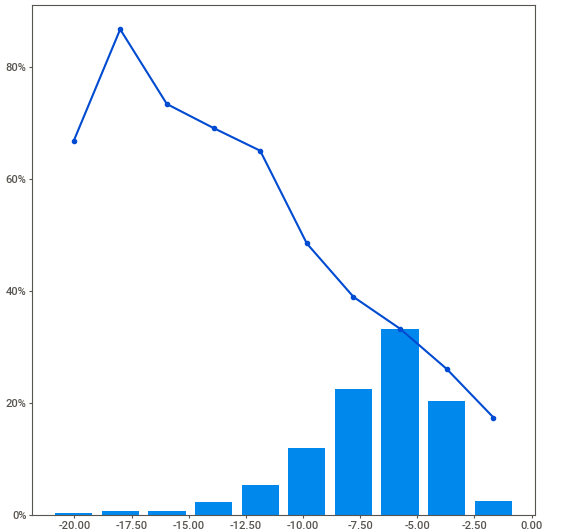
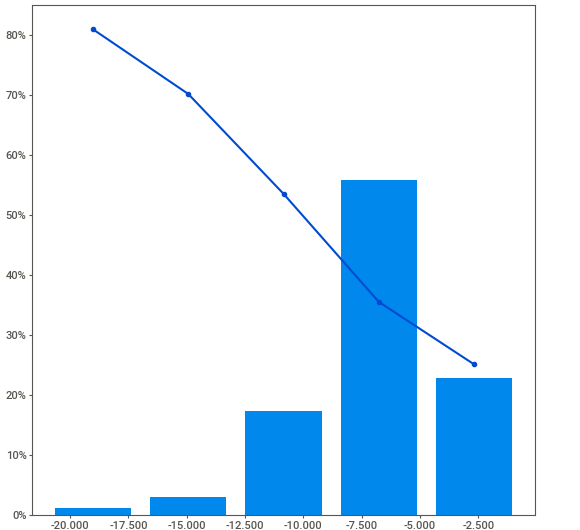
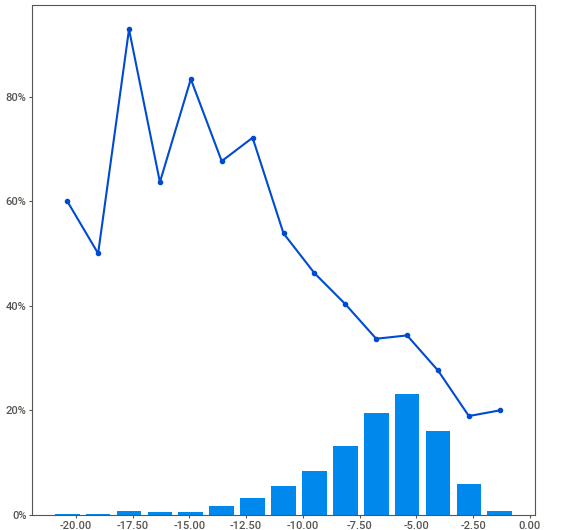
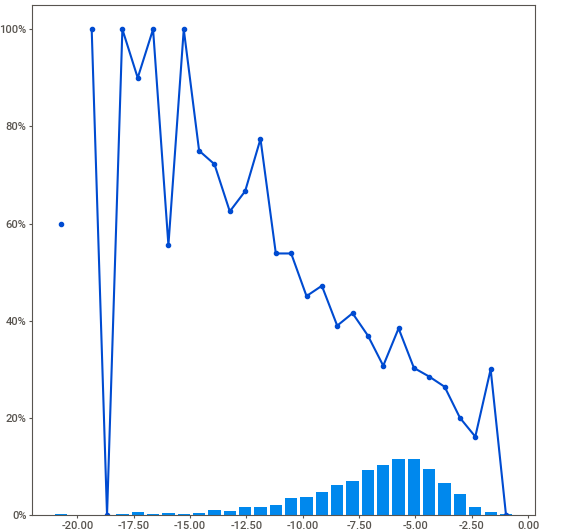
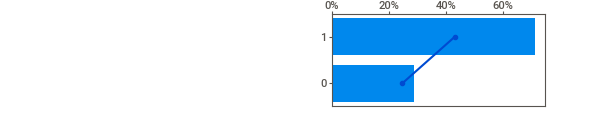
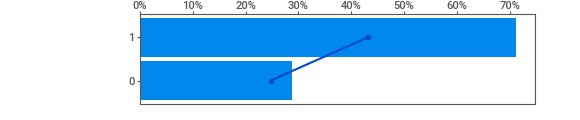
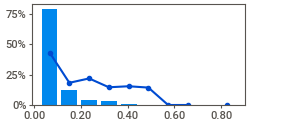
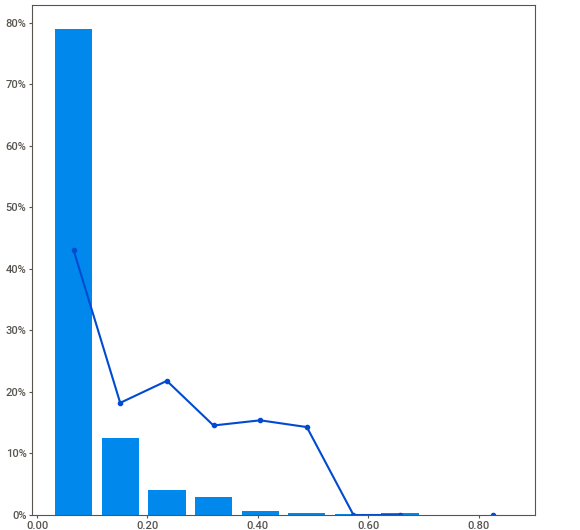
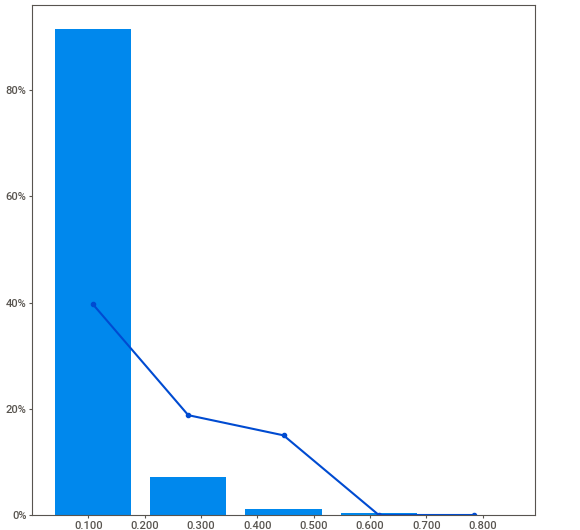
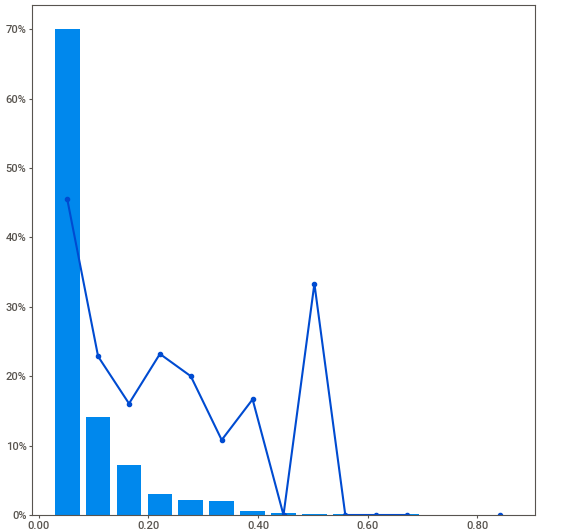
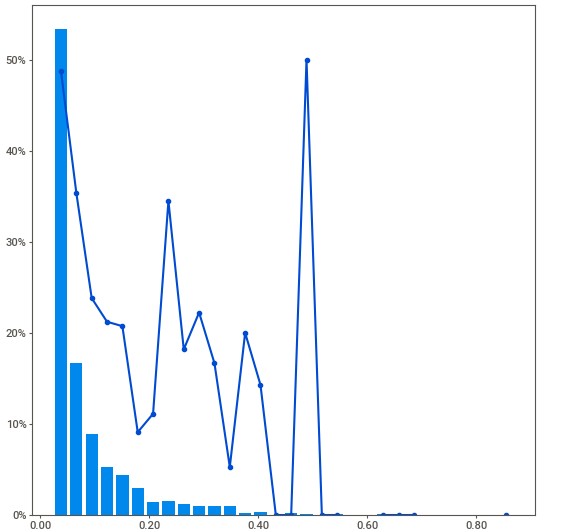
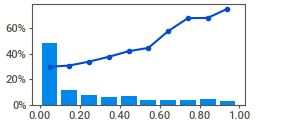
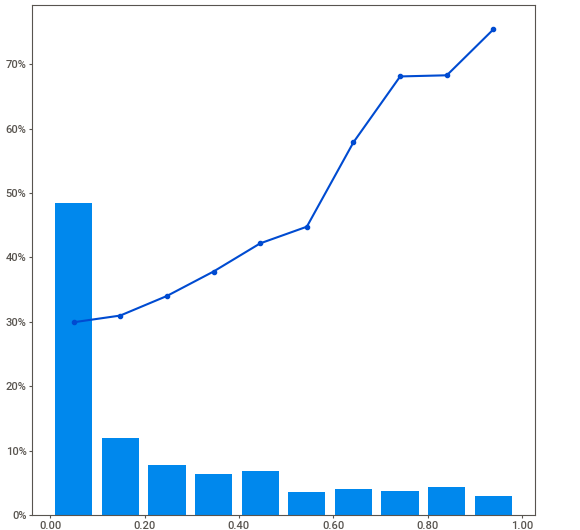
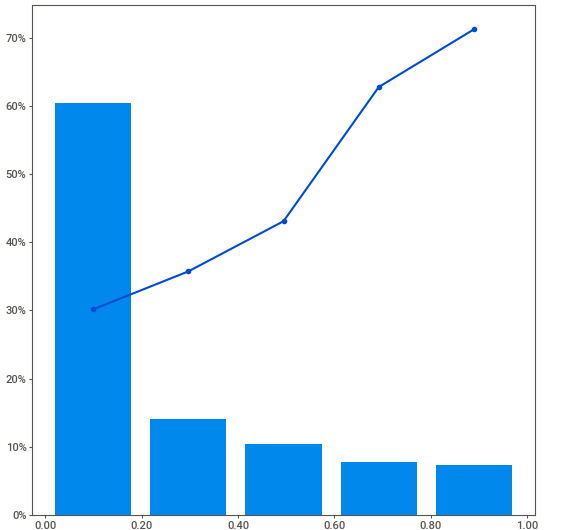
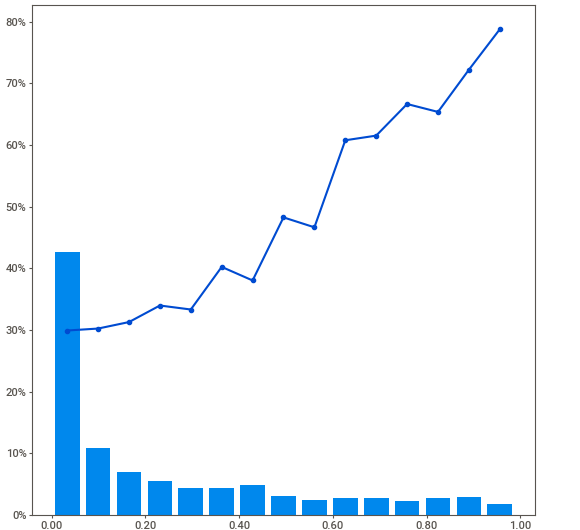
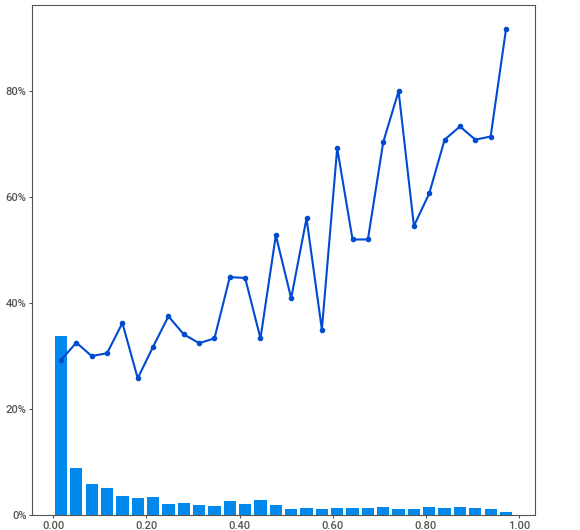
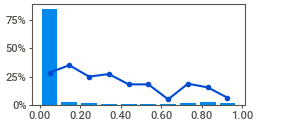
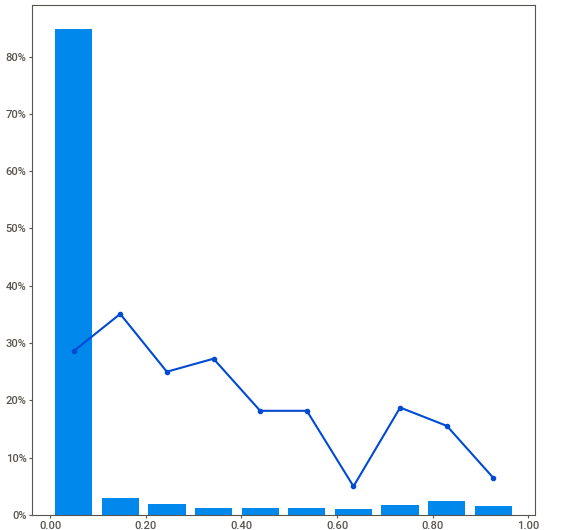
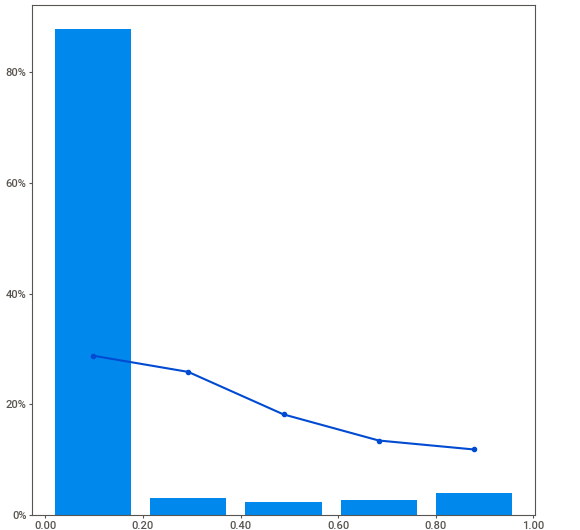
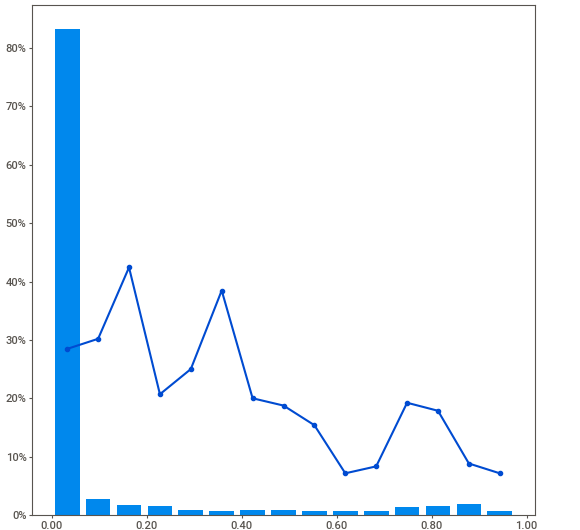
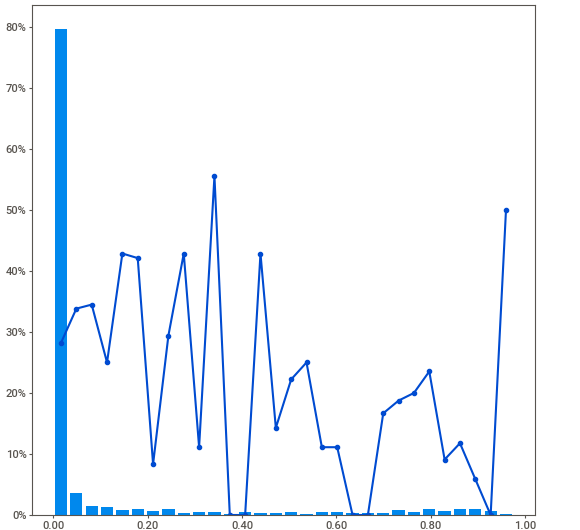
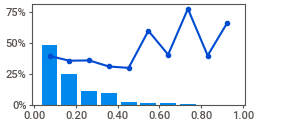
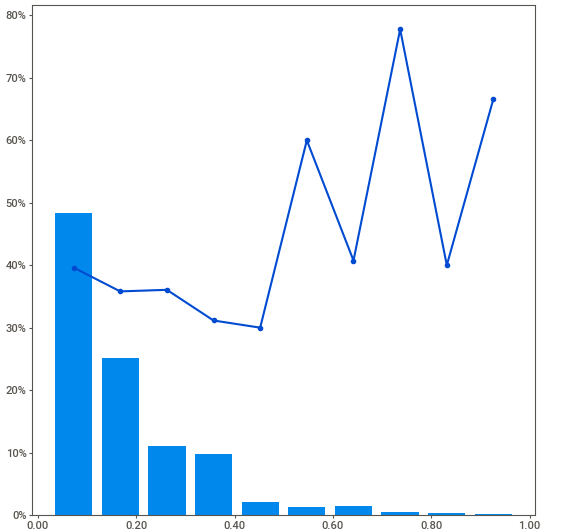
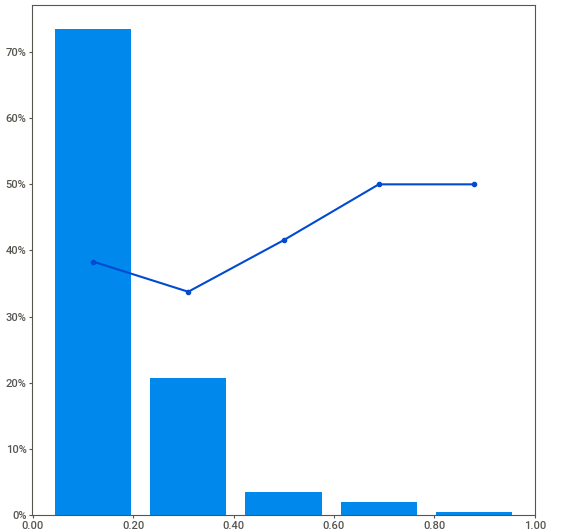
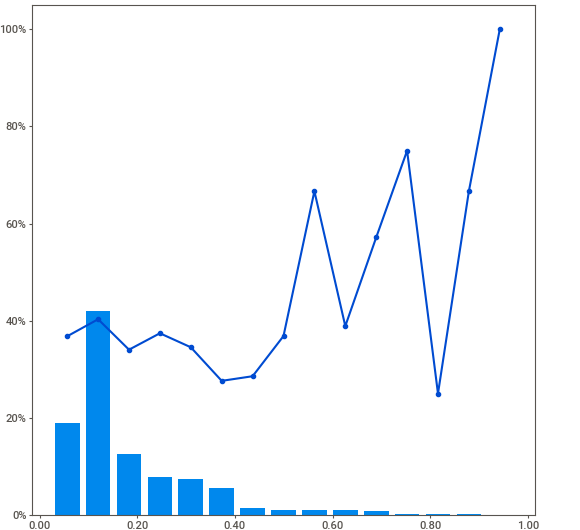
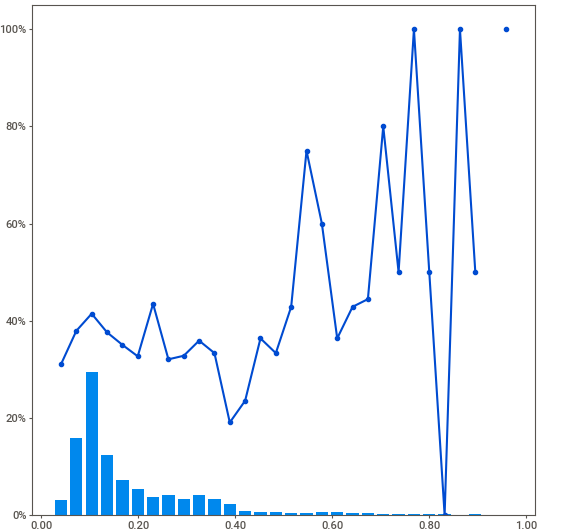
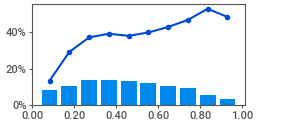
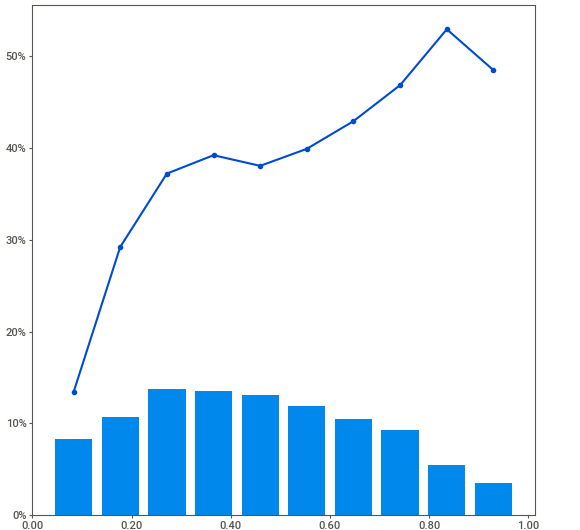
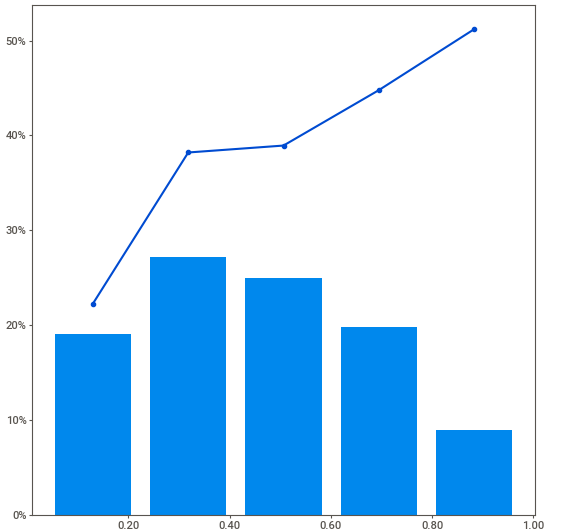
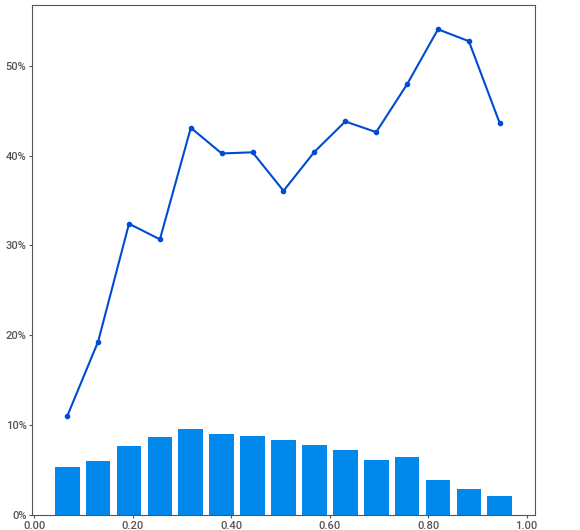
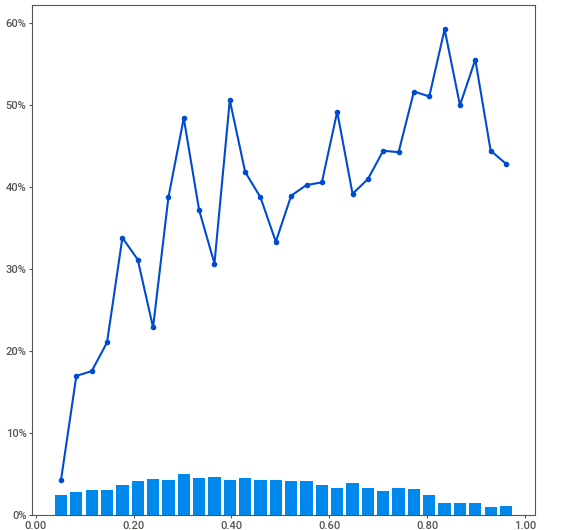
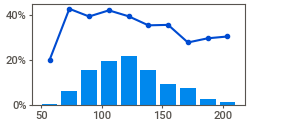
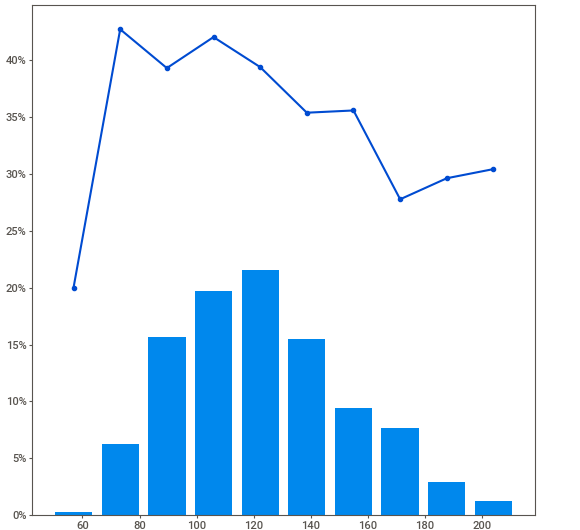
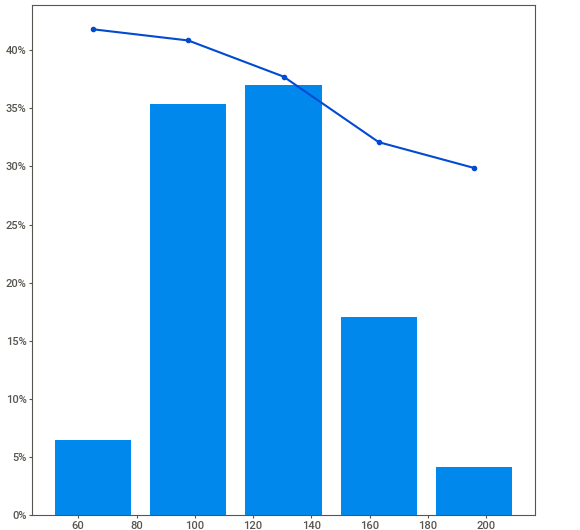
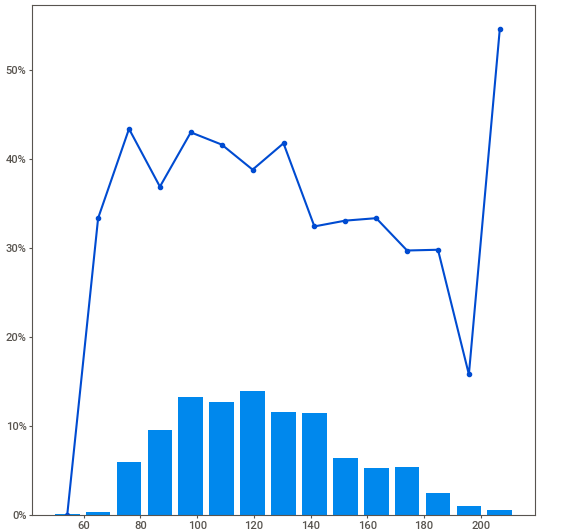
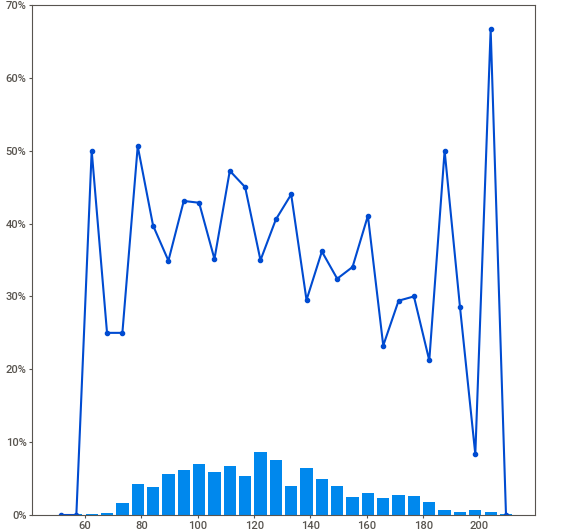
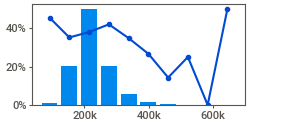
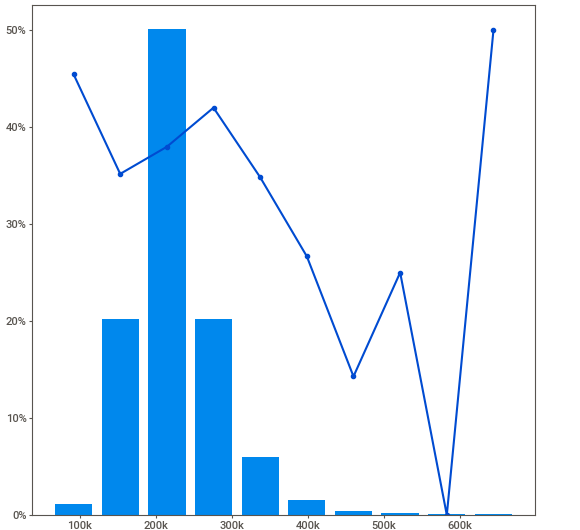
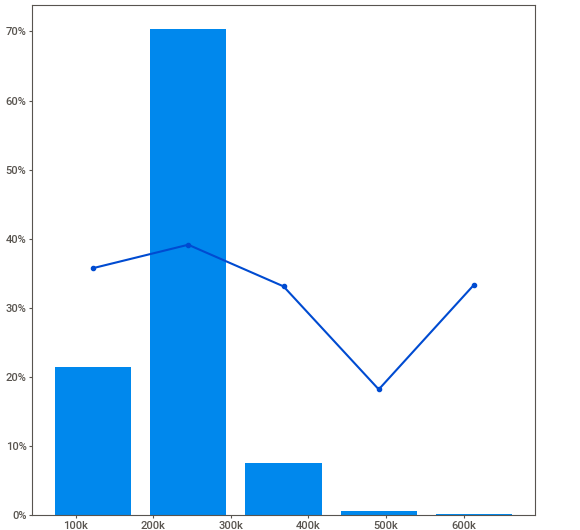
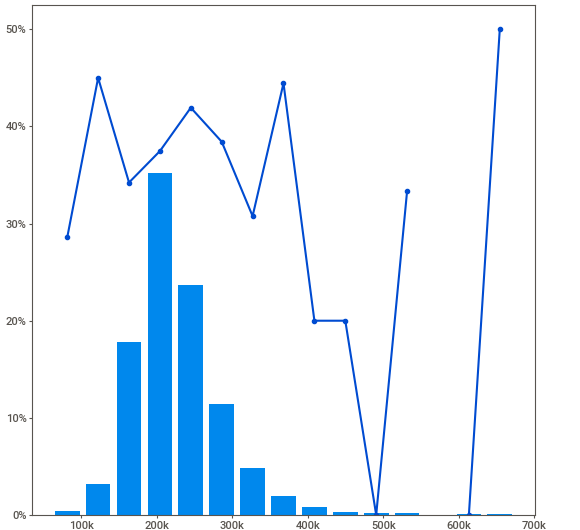
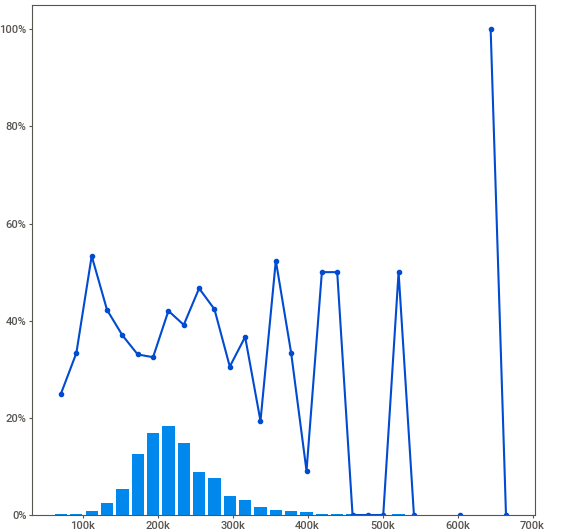
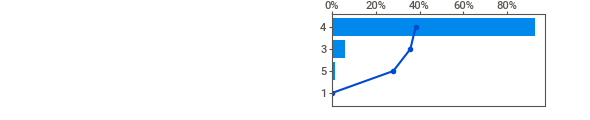
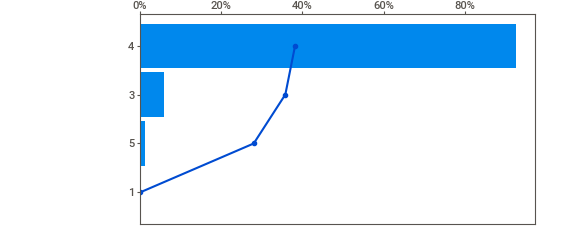
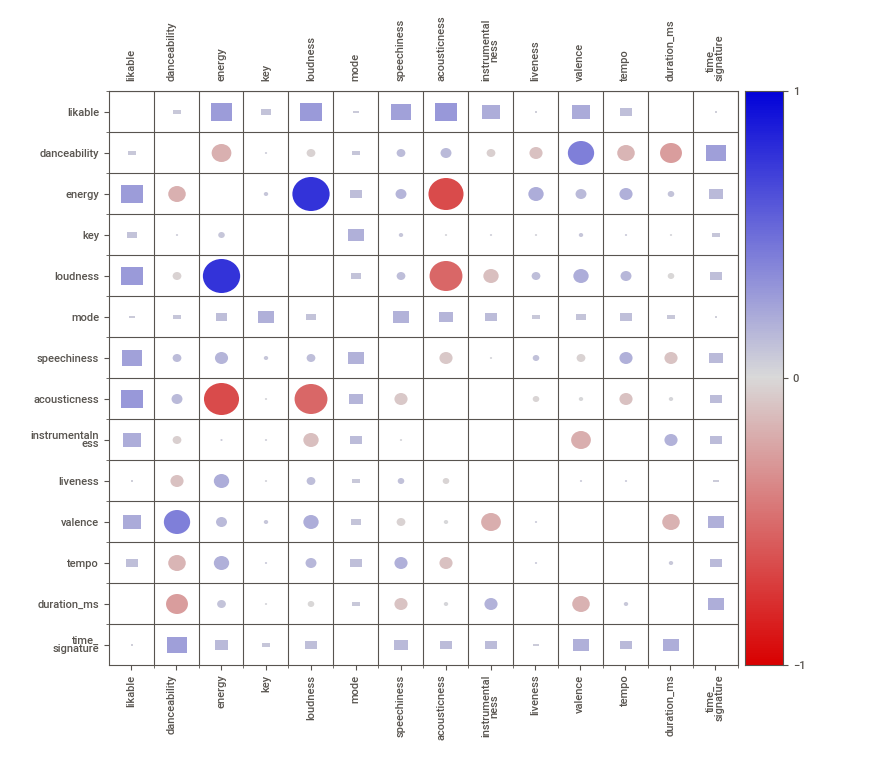
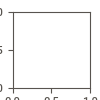

In [42]:
# For EDA, I tried Sweet Viz for the first time. I don't like the lack of customizable outputs, 
# but I think the grab-and-go version is helpful.

# The bar charts symbolize the percentage of the whole for each value,
# And the line chart represents what percentage of the values are "liked" songs. 
# Given that 38% of the values are liked songs, anything above that represents higher than expected values.
# Given that ID provides no numerical details regarding the features of a song, it should be ignored.


# Deprecation warnings in sweet viz are pretty common, so I surpressed them for now.
warnings.filterwarnings("ignore", category=FutureWarning)


analyze_report = sv.analyze(df, target_feat='likable', )
analyze_report.show_notebook()

In [43]:
fig = px.violin(df, y='acousticness', x='likable', box=True, points='all', color='likable')
fig.show()

In [44]:
pd.set_option('display.max_columns', None)

# Adding dummy values for categorical variables. 
dummies = ['key', 'time_signature']

# Given that not every key or signiture would be present in every input of songs, I had to make sure I dropped the same column
# after each call of get_dummies to properly fit the df to the ML model. Thus, I ignored the fist drop and added one later. 
df = pd.get_dummies(df, columns=dummies, drop_first=False)

good_columns = ['acousticness', 'danceability', 'duration_ms', 'energy',
    'instrumentalness', 'key_0', 'key_1', 'key_10', 'key_11', 'key_2', 'key_3',
    'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9',
    'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature_0', 'time_signature_1',
    'time_signature_3', 'time_signature_4', 'time_signature_5', 'time_signature_6', 
    'time_signature_7', 'valence']

empty_df = pd.DataFrame(columns=good_columns)
df = pd.merge(left=empty_df, right=df, how='outer')

df = df.drop(['key_0', 'time_signature_1'], axis=1)
df = df.fillna(0)
df = df.sort_index(axis=1)
df.head()


,acousticness,danceability,duration_ms,energy,id,instrumentalness,key_1,key_10,key_11,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,likable,liveness,loudness,mode,speechiness,tempo,time_signature_0,time_signature_3,time_signature_4,time_signature_5,time_signature_6,time_signature_7,valence
0,0.739,0.558,238133,0.304,4o8ASl77G362BEVsp3TuvB,0.000000,0,0,0,1,0,0,0,0,0,0,0,1,0.1170,-10.871,1,0.0347,127.502,0,0,1,0,0,0,0.195
1,0.103,0.623,211573,0.962,5PUawWFG1oIS2NwEcyHaCr,0.000174,0,0,0,0,0,1,0,0,0,0,0,1,0.2640,-2.616,0,0.0895,149.963,0,0,1,0,0,0,0.676
2,0.191,0.558,213547,0.889,25ran9X0iBOYnxFdP6c28n,0.000387,0,0,0,0,0,0,0,0,0,1,0,1,0.3280,-3.945,1,0.1020,170.102,0,0,1,0,0,0,0.716
3,0.480,0.834,239612,0.531,5erGUceK8ieHWtTXdnGP65,0.000000,0,0,0,0,1,0,0,0,0,0,0,1,0.0957,-10.450,1,0.1600,99.999,0,0,1,0,0,0,0.390
4,0.892,0.399,268264,0.318,26bCI2KTzz0ow6kL6FEl5Z,0.012500,0,1,0,0,0,0,0,0,0,0,0,1,0.1190,-13.482,1,0.0295,93.566,0,0,1,0,0,0,0.383


In [45]:
# All of this was to make the radar chart below. 

continuous_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
                      'liveness', 'valence', 'tempo', 'duration_ms', 'likable']

continuous_df = df[continuous_features].copy()
continuous_df['likable'] = continuous_df['likable'].astype('object')

continuous_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
                      'liveness', 'valence', 'tempo', 'duration_ms', 'likable']

scaler = MinMaxScaler()
good_again = continuous_df.loc[continuous_df['likable'] == 1]
good_norm = pd.DataFrame(scaler.fit_transform(good_again), columns = continuous_features)

bad_again = continuous_df.loc[continuous_df['likable'] == 0]
bad_norm = pd.DataFrame(scaler.fit_transform(bad_again), columns = continuous_features)


good_norm_mean = good_norm[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
                      'liveness', 'valence', 'tempo', 'duration_ms']].mean().to_frame().reset_index()

good_norm_mean.rename(columns={'index': 'feature',
                               0: 'norm_score'}, 
                                 inplace=True)

good_norm_mean['likable'] = 1


bad_norm_mean = bad_norm[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
                      'liveness', 'valence', 'tempo', 'duration_ms']].mean().to_frame().reset_index()

bad_norm_mean.rename(columns={'index': 'feature',
                               0: 'norm_score'}, 
                                 inplace=True)
bad_norm_mean['likable'] = 0


norms = [good_norm_mean, bad_norm_mean]

norm_mean_df = pd.concat(norms, ignore_index=True)

In [46]:
fig2 = px.line_polar(norm_mean_df, r="norm_score", theta="feature", color="likable", line_close=True,
                    color_discrete_sequence= ["lime", "red"], hover_name='norm_score', height=600,
                    title='Polar Chart of Normalized Features',
                    template="plotly_dark")

fig2.update_layout(font_family = 'Rockwell', title_x = 0.5)
fig2.update_traces(line=dict(width=2.5))
fig2.show()

In [47]:
fig3 = px.histogram(artist_df_import, x='artist_popularity', nbins=10, title="Histogram of Artist Popularity", 
                    labels={"artist_popularity": 'Artist Popularity'}, opacity=0.75, text_auto='.2f',
                    width=1750, height=800, color='likable', barmode="overlay", histnorm='percent')
fig3.update_layout(title_x = 0.5, title_font_family = "Arial", bargap=0.1, )
fig3.show()

In [14]:
df.to_csv('Spotify_Data.csv', index=False)

# Model Building

In [16]:
read_file = pd.read_csv('Spotify_Data.csv')
df2 = read_file.drop('id', axis=1)

df2 = df2.sort_index(axis=1)

In [22]:
scaled = StandardScaler()
X_columns = df2.drop('likable', axis=1).columns
X = df2.drop('likable', axis=1).values
Y = df2['likable'].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42, stratify=Y)
fit_scaler = scaled.fit(X_train)
X_train = fit_scaler.transform(X_train)

X_test = fit_scaler.transform(X_test)

scaler_file = "scaler_model.sav"
pickle.dump(fit_scaler, open(scaler_file, 'wb'))


In [18]:
def model_tester(model, parameters):
    start_time = time.time()


    # Maximizing F1
    cv_f1 = RandomizedSearchCV(model, param_distributions= parameters, cv=6, n_iter=150, scoring="f1", n_jobs=-1)
    cv_f1.fit(X_train, y_train) 
    y_pred_f1 = cv_f1.predict(X_test)   

    score_1 = round(precision_score(y_test, y_pred_f1, zero_division=0), 3)

    # Maximizing Precision
    cv_pre = RandomizedSearchCV(model, param_distributions= parameters, cv=6, n_iter=150, scoring="precision", n_jobs=-1)

    cv_pre.fit(X_train, y_train) 
    y_pred_pre = cv_pre.predict(X_test)
    y_pred_proba = cv_pre.predict_proba(X_test)

    score_2 = round(precision_score(y_test, y_pred_pre, zero_division=0), 3)

    print("Precision score for the F1 focused model: {} with {} tracks selected".format(score_1, sum(y_pred_f1)))
    print("Precision score for the precision focused model: {} with {} tracks selected".format(score_2, sum(y_pred_pre)))

    print("\nNumber of Tracks in the Training Data: {}".format(len(y_train)))
    print("Number of Tracks in Testing Data: {}".format(len(y_pred_pre)))
    
    print("\nTrue Positive Precision of Train Data: {}".format(round(cv_pre.score(X_train, y_train), 3)))
    print("True Positive Precision of Test Data: {}".format(round(cv_pre.score(X_test, y_test), 3)))
    print("\n Classification Report for the Test Data")
    print(classification_report(y_test, y_pred_pre))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_pre, cmap='Blues')
    plt.grid(False)
    plt.show()
    print("Tuned Model Parameters: {}".format(cv_pre.best_params_))

    optimized_parameters = cv_pre
    execution_time = (time.time() - start_time)
    print('\nExecution Time: {} seconds'.format(str(round(execution_time, 2))))
    return optimized_parameters, y_pred_pre, y_pred_f1, y_pred_proba

C:\Python310\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning:

The total space of parameters 24 is smaller than n_iter=150. Running 24 iterations. For exhaustive searches, use GridSearchCV.

C:\Python310\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning:

The total space of parameters 24 is smaller than n_iter=150. Running 24 iterations. For exhaustive searches, use GridSearchCV.



Precision score for the F1 focused model: 0.667 with 147 tracks selected
Precision score for the precision focused model: 0.882 with 34 tracks selected

Number of Tracks in the Training Data: 1412
Number of Tracks in Testing Data: 471

True Positive Precision of Train Data: 0.878
True Positive Precision of Test Data: 0.882

 Classification Report for the Test Data
              precision    recall  f1-score   support

           0       0.66      0.99      0.79       293
           1       0.88      0.17      0.28       178

    accuracy                           0.68       471
   macro avg       0.77      0.58      0.54       471
weighted avg       0.74      0.68      0.60       471



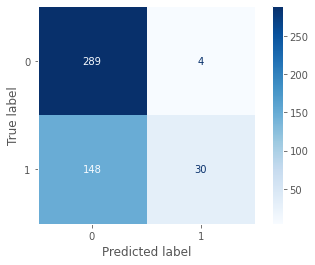

Tuned Model Parameters: {'kernel': 'rbf', 'gamma': 0.01, 'C': 0.1}

Execution Time: 12.89 seconds


In [24]:
parameters = {'C': [10, 1.0, 0.1, 0.01],
             'gamma': [1, 0.1, 0.01],
             'kernel': ['rbf', 'sigmoid']}

svc = SVC(probability=True)

optimized_svc, y_pred_pre, y_pred_f1, y_pred_proba = model_tester(svc, parameters)

tuned_svc = SVC(**optimized_svc.best_params_)

tuned_svc.fit(X_train, y_train)

svc_file = "svc_model.sav"
pickle.dump(tuned_svc, open(svc_file, 'wb'))

ROC AUC = 0.749


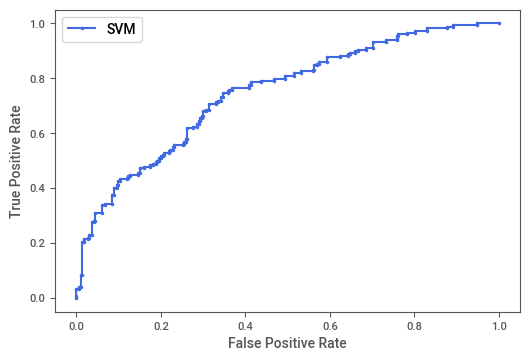

In [51]:
y_pred_proba_1 = y_pred_proba[:, 1]

auc = roc_auc_score(y_test, y_pred_proba_1)

print('ROC AUC = %.3f' % (auc))

fpr, tpr, _ = roc_curve(y_test, y_pred_proba_1)

plt.plot(fpr, tpr, marker='.', label='SVM', color="royalblue")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

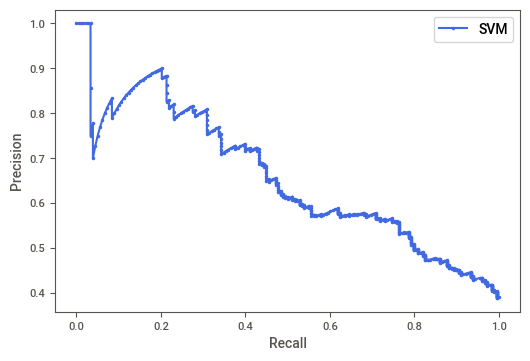

In [53]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_1)

plt.plot(recall, precision, marker='.', label='SVM', color="royalblue")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Finding Artists, Genres, and Top Tracks

## Using Spotify's Recommendation System

In [57]:
def get_artists(track_list):
    artist_name_empty = []
    artist_id_empty = []
    for i in track_list:
        song = sp.track(i)
        artist_name = song['album']['artists'][0]['name']
        artist_id = song['album']['artists'][0]['id']
        artist_name_empty.append(artist_name)
        artist_id_empty.append(artist_id)
    
    artist_df = pd.DataFrame(columns=['name', 'id'])
    artist_df['name'] = artist_name_empty
    artist_df['id'] = artist_id_empty
    return artist_df


def artist_details(df):
    artist_popularity_empty = []
    artist_genre_empty = []
    for i in df['id']:
        art = sp.artist(i)
        artist_pop = art['popularity']
        artist_genre = art['genres']
        artist_popularity_empty.append(artist_pop)
        artist_genre_empty.append(artist_genre)
    
    df['artist_popularity'] = artist_popularity_empty
    df['artist_genre'] = artist_genre_empty
    return df


good_list_df = pd.read_csv("good_list.csv")

artists = get_artists(good_list_df['song_id'])

artist_info = artist_details(artists)

set_artists = artist_info.loc[artist_info.astype(str).drop_duplicates().index].reset_index(drop=True)



In [52]:
fig4 = px.histogram(artist_info, x='artist_popularity', nbins=10, title="Histogram of Artist Popularity", 
                    labels={"artist_popularity": 'Artist Popularity'}, opacity=0.75, text_auto=True,
                    width=1500, height=700)
fig4.update_layout(title_x = 0.5, title_font_family = "Arial", bargap=0.1)
fig4.show()

In [79]:
under_45_pop = artist_info[artist_info['artist_popularity'] < 45].reset_index(drop=True)
u_45 = under_45_pop['name'].value_counts()

artists_top_20 = list(under_45_pop['id'].value_counts().index[1:21])

u_45.head(20)


Various Artists                             12
Joe Kaplow                                   6
L.A. Salami                                  5
Walter Mitty and His Makeshift Orchestra     2
Scythian                                     2
Sonny Cleveland                              2
Cloud Control                                2
Lil Pøøch                                    2
Felix Riebl                                  2
Little Green Cars                            1
Tanya Davis                                  1
Sonntag                                      1
Brandtson                                    1
Toh Kay                                      1
Jeremy Fisher                                1
Bad Veins                                    1
Opus Orange                                  1
Gisbert Zu Knyphausen                        1
Star & Micey                                 1
The Apache Relay                             1
Name: name, dtype: int64

In [73]:
genre_list = []
genres = set_artists.artist_genre

for artist in genres:
    for i in artist:
        genre_list.append(i)

genre_ser = pd.Series(genre_list).value_counts()
print(genre_ser.head(20))

genre_top_20 = list(pd.Series(genre_list).value_counts().index[:20])

modern rock                99
stomp and holler           87
rock                       75
pop rock                   68
indie folk                 62
indie pop                  57
indie rock                 48
alternative rock           33
pop                        32
modern alternative rock    30
new americana              27
classic rock               24
deep new americana         22
permanent wave             22
indie poptimism            21
folk-pop                   18
rap                        17
indiecoustica              17
neo mellow                 16
hip hop                    16
dtype: int64


In [74]:
five_stars = ['5arQr8hN0f7hej3PjeEF6h']
five_stars_id = get_tracks(five_stars)

In [75]:
def get_recommendations(seed_art, seed_genre, seed_track, popularity):
    new_art_list = []
    new_track_list = []
    new_pop_list = []

    df = pd.DataFrame(columns=['artist_id', 'track_id', 'artist_popularity'])

    rand_art = seed_art[random.randint(0, len(seed_art)-1)]
    rand_genre = seed_genre[random.randint(0, len(seed_genre)-1)]
    rand_track = seed_track[random.randint(0, len(five_stars_id)-1)]

    recs = sp.recommendations(seed_artists=[rand_art], seed_genres=[rand_genre], seed_tracks=[rand_track], 
    limit=25, max_popularity = popularity)

    # Get the song's id
    data = recs['tracks']
    for i, other in enumerate(data):
        track = data[i]
        id = track['id']
        new_track_list.append(id)

    # get the song's artist id
    # get the artist's popularity
    for i, other in enumerate(data):
        track = data[i]
        artist = track['album']['artists'][0]['id']
        new_art_list.append(artist)

    
    df['artist_id'] = new_art_list
    df['track_id'] = new_track_list


    for i in df['artist_id']:
        art = sp.artist(i)
        artist_pop = art['popularity']
        new_pop_list.append(artist_pop)

    df['artist_popularity'] = new_pop_list
    return df
        


def get_more_tracks():

    df = pd.DataFrame(columns=['artist_id', 'track_id', 'artist_popularity'])
    i = 0
    while i < 41:
        recs = get_recommendations(artists_top_20, genre_top_20, five_stars_id, 20)
        df = pd.concat([df, recs])
        i += 1
        time.sleep(0.5)

    return df





In [76]:
new_tracks = get_more_tracks()

In [86]:
new_tracks['artist_popularity'] = pd.to_numeric(new_tracks['artist_popularity'])
below_35 = new_tracks[new_tracks['artist_popularity'] < 35].reset_index(drop=True)
below_35

,artist_id,track_id,artist_popularity
0,19QzBfgfbcbByY8SFvXA2F,6lFhJYmtKOXUmMsHf831KI,32
1,19QzBfgfbcbByY8SFvXA2F,62a820hkgJ6IgiNWh7HdU7,32
2,19QzBfgfbcbByY8SFvXA2F,2483eK3rUhFV90qN5WZRwG,32
3,19QzBfgfbcbByY8SFvXA2F,1Iq9rraJlm8QGfIe7rwmmx,32
4,19QzBfgfbcbByY8SFvXA2F,1odRIwo8Jgbs53wdMFDcSZ,32
...,...,...,...
362,0LyfQWJT6nXafLPZqxe9Of,4jfq7rJdNS77eNIKOmxS1B,0
363,0LyfQWJT6nXafLPZqxe9Of,1qQmbloP2MwRT7sXaiXpJn,0
364,0LyfQWJT6nXafLPZqxe9Of,0P4JXKTcmdslasjPfRJHFd,0
365,0LyfQWJT6nXafLPZqxe9Of,108Q7fPYVSeLbPu2fKcbK5,0


In [138]:
Spotify_Rec = [below_35, Spotify_Recommendations]
Spotify_Rec_Join = pd.concat(Spotify_Rec).drop_duplicates(keep="first")
Spotify_Rec_Join.to_csv("SP_Recommendations_Artists_Tracks.csv", index=False)

## Using Less-Popular Artists to find other Less-Popular Artists

In [77]:
# get similar artists to the top 20 atists
def simular_artists(artist_list):
    sims = pd.DataFrame(columns=['artist_id', 'artist_pop'])
    similar_artists = []
    similar_artists_pop = []

    for i in artist_list:
        simular = sp.artist_related_artists(i)
        for x in simular['artists']:

            id = x['id']
            similar_artists.append(id)

            pop = x['popularity']
            similar_artists_pop.append(pop)

    sims['artist_id'] = similar_artists
    sims['artist_pop'] = similar_artists_pop    

    return sims

def get_art_tracks(art_list):
    art_top_10 = pd.DataFrame(columns=['track_id', 'track_popularity'])
    track_id = []
    track_pop = []

    for i in art_list:
        tracks = sp.artist_top_tracks(i)
        for x in tracks['tracks']:
            track = x['id'] 
            track_id.append(track)

            pop = x['popularity']
            track_pop.append(pop)


    art_top_10['track_id'] = track_id
    art_top_10['track_popularity'] = track_pop

    return art_top_10

In [80]:
simular_arts = simular_artists(artists_top_20)

top_10_tracks = get_art_tracks(simular_arts['artist_id'])

In [81]:
art_top_10 = top_10_tracks.drop_duplicates(keep='first')

print(len(top_10_tracks))
print(len(art_top_10))

3745
3454


In [82]:
art_top_10

,track_id,track_popularity
0,0nJkRTWpbpTYxHVNk4bMlb,42
1,0XR5gm7hvvlE8iEst9sX2F,39
2,0ts5jQ37JLqYBUvvzaVnwR,34
3,2qBP7RSUJtjwGLsh4nsuqS,34
4,6Z1QoIjMSzMzYRyCIbt1pA,33
...,...,...
3740,5XhKaVWp5W7A1GmXLBdlj8,17
3741,0AcPfoNCLhXMNerWJXY5Vr,16
3742,0C8LIZYSHemAhupRDQKHw9,13
3743,33SdMMKgMtkKyC9pt9OXBR,12


In [83]:
fig5 = px.histogram(art_top_10, x='track_popularity', title="Histogram of Recommended Track Popularity", nbins=15,
                    labels={"track_popularity": 'Track Popularity'}, opacity=0.75, text_auto=True,
                    width=1500, height=700)
fig5.update_layout(title_x = 0.5, title_font_family = "Arial", bargap=0.1)
fig5.show()

In [84]:
def check_occurance(input_tracks, known_tracks):
    empty_track_list = []

    for track in input_tracks:
        if track in known_tracks:
            pass
        else:
            empty_track_list.append(track)
    return empty_track_list

In [89]:
rec_tracks_list = check_occurance(below_35['track_id'], good_list_df['song_id'])

rec_tracks = add_features(below_35['track_id'])

50 songs have been completed. 317 songs remain.
100 songs have been completed. 267 songs remain.
150 songs have been completed. 217 songs remain.
200 songs have been completed. 167 songs remain.
250 songs have been completed. 117 songs remain.
300 songs have been completed. 67 songs remain.
350 songs have been completed. 17 songs remain.


In [128]:
art_top_10_tracks = check_occurance(art_top_10['track_id'], good_list_df['song_id'])

sim_arts_tracks = add_features(art_top_10_tracks)

50 songs have been completed. 3428 songs remain.
100 songs have been completed. 3378 songs remain.
150 songs have been completed. 3328 songs remain.
200 songs have been completed. 3278 songs remain.
250 songs have been completed. 3228 songs remain.
300 songs have been completed. 3178 songs remain.
350 songs have been completed. 3128 songs remain.
400 songs have been completed. 3078 songs remain.
450 songs have been completed. 3028 songs remain.
500 songs have been completed. 2978 songs remain.
550 songs have been completed. 2928 songs remain.
600 songs have been completed. 2878 songs remain.
650 songs have been completed. 2828 songs remain.
700 songs have been completed. 2778 songs remain.
750 songs have been completed. 2728 songs remain.
800 songs have been completed. 2678 songs remain.
850 songs have been completed. 2628 songs remain.
900 songs have been completed. 2578 songs remain.
950 songs have been completed. 2528 songs remain.
1000 songs have been completed. 2478 songs remain.


In [145]:
Features_SP = [rec_tracks, Features_SP_Rec]
Features_SP_Join = pd.concat(Features_SP).drop_duplicates(keep='first')
Features_SP_Join.to_csv("Features_Using_SP_Rec.csv", index=False)

Features_Sim_Art = [sim_arts_tracks, Features_SP_Rec]
Features_Sim_Join = pd.concat(Features_Sim_Art).drop_duplicates(keep='first')
Features_Sim_Join.to_csv("Features_Using_Sim_Art.csv", index=False)

In [26]:
scaler_file = "scaler_model.sav"
loaded_scaler = pickle.load(open(scaler_file, 'rb'))

svc_file = "svc_model.sav"
loaded_model = pickle.load(open(svc_file, 'rb'))

def cleaning_function(df):

    df = df.drop_duplicates(keep='first')

    id = list(df['id'])

    cols_to_drop = ['type', 'uri', 'track_href', 'analysis_url', 'id']
    

    df = df.drop(cols_to_drop, axis=1)


    dummies = ['key', 'time_signature']
    df = pd.get_dummies(df, columns=dummies, drop_first=False)

    good_columns = ['acousticness', 'danceability', 'duration_ms', 'energy',
        'instrumentalness', 'key_0', 'key_1', 'key_10', 'key_11', 'key_2', 'key_3',
        'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9',
        'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature_0', 'time_signature_1',
        'time_signature_3', 'time_signature_4', 'time_signature_5', 'time_signature_6', 
        'time_signature_7', 'valence']

    empty_df = pd.DataFrame(columns=good_columns)
    df2 = pd.merge(left=empty_df, right=df, how='outer')
    df2 = df2.drop(['key_0', 'time_signature_1'], axis=1)

    df2 = df2.fillna(0)
    df2 = df2.sort_index(axis=1)

    X_2 = df2.values
    scaled_X = pd.DataFrame(loaded_scaler.transform(X_2))
    predictions = loaded_model.predict(scaled_X)

    joined_df = pd.DataFrame(columns=['prediction', 'track_id'])
    joined_df['prediction'] = predictions
    joined_df['track_id'] = id

    return joined_df



In [27]:
copy_rec_tracks = Features_SP_Rec.copy()
copy_sim_tracks = Features_Sim_Art.copy()

rec_predictions = cleaning_function(copy_rec_tracks)
sim_art_predictions = cleaning_function(copy_sim_tracks)

In [28]:
rec_yes = rec_predictions[rec_predictions['prediction'] == 1 ]
print("Number of recommended songs from Spotify's recommendations: {}".format(len(rec_yes)))

Number of recommended songs from Spotify's recommendations: 17


In [29]:
sim_yes = sim_art_predictions[sim_art_predictions['prediction'] == 1]
print("Number of recommended songs using similar artist's top songs: {}".format(len(sim_yes)))

Number of recommended songs using similar artist's top songs: 576


In [92]:
imported = pd.read_csv("Initial_Data_with_Features.csv")

known_tracks = imported['id']

def add_to_playlist(df, playlist_id):
    
    input_playlist = [playlist_id]
    current_tracks = get_tracks(input_playlist)

    tracks_sim = list(df['track_id'])

    add_these = []

    for x in tracks_sim:
        if x in current_tracks:
            pass
        elif x in known_tracks:
            pass
        else:
            add_these.append(x)
    print("Number of added Tracks: {}".format(len(add_these)))

    start = 0
    end = 99
    length = math.ceil(len(add_these)/100)

    for i in range(0, length):
        tracks_sim_temp = add_these[start:end]
        sp.user_playlist_add_tracks(user='12160507700', playlist_id=playlist_id, tracks=tracks_sim_temp)
        start += 100
        end += 100
        time.sleep(2)

In [94]:
add_to_playlist(rec_yes, "02vgoWKLijGtiqD6hLwTgX")
add_to_playlist(sim_yes, "1c0PzPgIKSGCESe2IEtJNf")

Number of added Tracks: 0
Number of added Tracks: 0


# Useless Models

In [43]:
# KNN

params = {"n_neighbors": range(1, 21, 2),
          "leaf_size": range(1, 30),
          'metric': ['euclidean', 'manhattan', 'minkowski'],
          'weights': ['uniform', 'distance']}

knn = KNeighborsClassifier()

optimized_knn = model_tester(knn, params)

tuned_knn = KNeighborsClassifier(**optimized_knn.best_params_)

Accuracy of Train Data: 0.752
Accuracy of Test Data: 0.678

 Classification Report for the Test Data
              precision    recall  f1-score   support

           0       0.83      0.78      0.80       335
           1       0.68      0.75      0.71       210

    accuracy                           0.77       545
   macro avg       0.76      0.76      0.76       545
weighted avg       0.77      0.77      0.77       545

Tuned Model Parameters: {'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'uniform'}

Execution Time: 113.7 seconds


In [ ]:
# Decision Trees
# review min sample leaf
# changed max depth range, added n_estimators
'''

full_params = {"max_depth": range(3, 9, 2),
              "min_samples_leaf": range(1, 10),
              "criterion": ["gini", "entropy"]}

tree = DecisionTreeClassifier()

optimized_tree = model_tester(tree, params)

tuned_tree = DecisionTreeClassifier(**optimized_tree.best_params_)'''

In [79]:
def model_tester(model, parameters, X_train, X_test):
    start_time = time.time()


    # Maximizing F1
    cv_f1 = RandomizedSearchCV(model, param_distributions=parameters, n_iter=100, cv=6, scoring="f1", n_jobs=-1)
    cv_f1.fit(X_train, y_train) 
    y_pred_f1 = cv_f1.predict(X_test)   

    score_1 = round(precision_score(y_test, y_pred_f1, zero_division=0), 3)

    # Maximizing Precision
    cv_pre = RandomizedSearchCV(model, param_distributions=parameters, n_iter=100, cv=6, scoring="precision", n_jobs=-1)
    cv_pre.fit(X_train, y_train) 
    y_pred_pre = cv_pre.predict(X_test)
    y_pred_proba = cv_pre.predict_proba(X_test)

    score_2 = round(precision_score(y_test, y_pred_pre, zero_division=0), 3)

    print("Precision score for the F1 focused model: {} with {} tracks selected".format(score_1, sum(y_pred_f1)))
    print("Precision score for the precision focused model: {} with {} tracks selected".format(score_2, sum(y_pred_pre)))

    print("\nNumber of Tracks in the Training Data: {}".format(len(y_train)))
    print("Number of Tracks in Testing Data: {}".format(len(y_pred_pre)))
    
    print("\nTrue Positive Precision of Train Data: {}".format(round(cv_pre.score(X_train, y_train), 3)))
    print("True Positive Precision of Test Data: {}".format(round(cv_pre.score(X_test, y_test), 3)))
    print("\n Classification Report for the Test Data")
    print(classification_report(y_test, y_pred_pre))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_pre, cmap='Blues')
    plt.grid(False)
    plt.show()
    print("Tuned Model Parameters: {}".format(cv_pre.best_params_))

    optimized_parameters = cv_pre
    execution_time = (time.time() - start_time)
    print('\nExecution Time: {} seconds'.format(str(round(execution_time, 2))))
    return optimized_parameters, y_pred_pre, y_pred_f1, y_pred_proba

In [84]:
# Random Forest

params = {"max_features": ['sqrt', 'log2'],
          'n_estimators': [10, 100, 500, 1000],
          "min_samples_leaf": [1, 2, 4],
          "min_samples_split": [2, 5, 8]}

rf = RandomForestClassifier()

optimized_rf, y_pred_pre_rf, y_pred_f1_rf, y_pred_proba_rf = model_tester(rf, params, X_train=X_train, X_test=X_test)

tuned_rf = RandomForestClassifier(**optimized_rf.best_params_)
tuned_rf.fit(X_train, y_train)

C:\Python310\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning:

The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.



KeyboardInterrupt: 

In [61]:
tuned_rf.feature_importances_

array([0.11744763, 0.08109288, 0.07056816, 0.10823684, 0.084863  ,
       0.00429545, 0.00168146, 0.00261897, 0.00365041, 0.00122106,
       0.0036248 , 0.00332098, 0.00657264, 0.00338251, 0.00376555,
       0.00511199, 0.05931385, 0.10269451, 0.02548303, 0.12272838,
       0.06826664, 0.        , 0.00196371, 0.00243902, 0.00041578,
       0.        , 0.        , 0.11524076])

<BarContainer object of 28 artists>

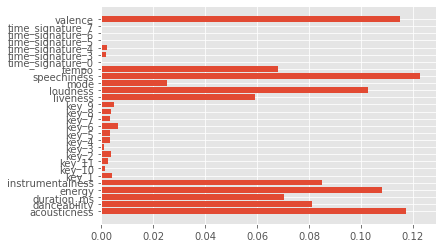

In [63]:
plt.barh(X_columns, tuned_rf.feature_importances_)

In [80]:
pca = PCA(n_components=0.95)
pca.fit(X_train)
pca_X_train = pca.transform(X_train)
pca_X_test = pca.transform(X_test)

In [77]:
line = px.bar(np.cumsum(pca.explained_variance_ratio_))
line.show()

C:\Python310\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning:

The total space of parameters 18 is smaller than n_iter=100. Running 18 iterations. For exhaustive searches, use GridSearchCV.

C:\Python310\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning:

The total space of parameters 18 is smaller than n_iter=100. Running 18 iterations. For exhaustive searches, use GridSearchCV.



Precision score for the F1 focused model: 0.638 with 130 tracks selected
Precision score for the precision focused model: 0.811 with 37 tracks selected

Number of Tracks in the Training Data: 1412
Number of Tracks in Testing Data: 471

True Positive Precision of Train Data: 0.898
True Positive Precision of Test Data: 0.811

 Classification Report for the Test Data
              precision    recall  f1-score   support

           0       0.66      0.98      0.79       293
           1       0.81      0.17      0.28       178

    accuracy                           0.67       471
   macro avg       0.73      0.57      0.53       471
weighted avg       0.72      0.67      0.59       471



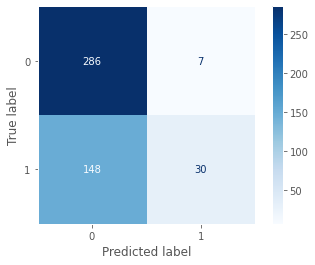

Tuned Model Parameters: {'kernel': 'rbf', 'gamma': 0.01, 'C': 0.1}

Execution Time: 6.76 seconds


In [91]:
params = {"max_features": ['sqrt', 'log2'],
          'n_estimators': [10, 100, 500, 1000],
          "min_samples_leaf": [1, 2, 4],
          "min_samples_split": [2, 5, 8]}

svc_params = {'C': [0.5, 0.1, 0.01],
             'gamma': [0.005, 0.01, 0.1],
             'kernel': ['rbf', 'sigmoid']}

svc = SVC(probability=True)


pca_rf, y_pred_pre_rf, y_pred_f1_rf, y_pred_proba_rf = model_tester(svc, svc_params, X_train=pca_X_train, X_test=pca_X_test)

#tuned_rf = RandomForestClassifier(**optimized_rf.best_params_)
#tuned_rf.fit(X_train, y_train)

Precision score for the F1 focused model: 0.724 with 116 tracks selected
Precision score for the precision focused model: 0.725 with 120 tracks selected

Number of Tracks in the Training Data: 1412
Number of Tracks in Testing Data: 471

True Positive Precision of Train Data: 0.996
True Positive Precision of Test Data: 0.725

 Classification Report for the Test Data
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       293
           1       0.72      0.49      0.58       178

    accuracy                           0.74       471
   macro avg       0.73      0.69      0.70       471
weighted avg       0.73      0.74      0.72       471



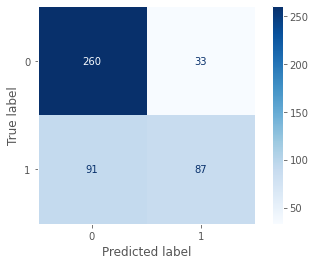

Tuned Model Parameters: {'max_features': 'sqrt', 'n_estimators': 1000}

Execution Time: 50.48 seconds


In [48]:
# Random Forest

params = {"max_features": ['sqrt', 'log2', 'auto'],
          'n_estimators': [10, 100, 500, 1000],
          "min_samples_leaf": [1, 2, 4],
          "min_samples_split": [2, 5, 8]}

rf = RandomForestClassifier()

optimized_rf, y_pred_pre_rf, y_pred_f1_rf, y_pred_proba_rf = model_tester(rf, params)

tuned_rf = RandomForestClassifier(**optimized_rf.best_params_)

C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMet

Precision score for the F1 focused model: 0.615 with 143 tracks selected
Precision score for the precision focused model: 0.852 with 27 tracks selected

Number of Tracks in the Training Data: 1411
Number of Tracks in Testing Data: 471

True Positive Precision of Train Data: 0.901
True Positive Precision of Test Data: 0.852

 Classification Report for the Test Data
              precision    recall  f1-score   support

           0       0.65      0.99      0.78       293
           1       0.85      0.13      0.22       178

    accuracy                           0.66       471
   macro avg       0.75      0.56      0.50       471
weighted avg       0.73      0.66      0.57       471



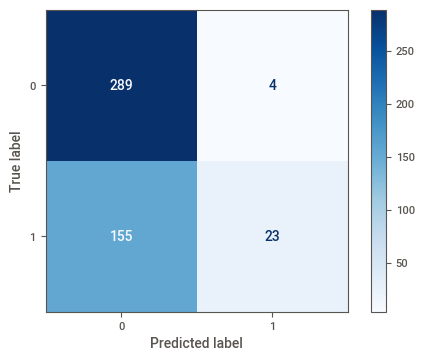

Tuned Model Parameters: {'C': 0.0007196856730011522, 'penalty': 'l2', 'solver': 'newton-cg'}

Execution Time: 5.64 seconds


(GridSearchCV(cv=5, estimator=LogisticRegression(),
              param_grid={'C': array([1.00000000e-05, 8.48342898e-05, 7.19685673e-04, 6.10540230e-03,
        5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
        2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
        1.38949549e+06, 1.17876863e+07, 1.00000000e+08]),
                          'penalty': ['l2'],
                          'solver': ['newton-cg', 'lbfgs', 'liblinear']},
              scoring='precision'),
 array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [35]:
# Logistic Regression

c_space = np.logspace(-5, 8, 15)
params = {"C": c_space,
          "penalty": ['l2'],
          'solver': ['newton-cg', 'lbfgs', 'liblinear']}

lr = LogisticRegression()

model_tester(lr, params)

C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no pr

Accuracy of Train Data: 0.875
Accuracy of Test Data: 0.786

 Classification Report for the Test Data
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       335
           1       0.79      0.44      0.56       210

    accuracy                           0.74       545
   macro avg       0.76      0.68      0.69       545
weighted avg       0.75      0.74      0.72       545



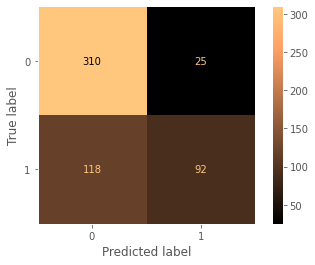

Tuned Model Parameters: {'max_depth': 4, 'min_samples_split': 400, 'n_estimators': 5}

Execution Time: 56.65 seconds


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': range(2, 6, 2),
                         'min_samples_split': range(200, 1000, 200),
                         'n_estimators': [5, 50, 250, 500]},
             scoring='precision')

In [ ]:
params = {'n_estimators': [5, 50, 250, 500],
          'min_samples_split': range(200, 1000, 200),
          'max_depth': range(2, 6, 2)}

gb = GradientBoostingClassifier()

model_tester(gb, params)

In [98]:
# SVC
# Make stacked bar charts
# add dif. C values, kernals, kernel = ['poly', 'rbf', 'sigmoid']#C = [50, 10, 1.0, 0.1, 0.01]
steps = [('scaler', StandardScaler()),
         ('SVM', SVC())]

pipeline = Pipeline(steps)

parameters = {'SVM__C':[1, 10, 100],
             'SVM__gamma':[0.1, 0.01]}

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

cv = GridSearchCV(pipeline, param_grid = parameters, cv=5)

cv.fit(X_train, y_train)

y_pred = cv.predict(X_test)

print("Accuracy: {}".format(cv.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(cv.best_params_))

Accuracy: 0.7871559633027523
              precision    recall  f1-score   support

           0       0.84      0.81      0.82       335
           1       0.71      0.75      0.73       210

    accuracy                           0.79       545
   macro avg       0.78      0.78      0.78       545
weighted avg       0.79      0.79      0.79       545

Tuned Model Parameters: {'SVM__C': 10, 'SVM__gamma': 0.01}


# Useless Bin

In [ ]:
tracks_rec = list(rec_yes['track_id'])
sp.user_playlist_add_tracks(user='12160507700', playlist_id="02vgoWKLijGtiqD6hLwTgX", tracks=tracks_rec)

{'snapshot_id': 'Myw5OWI4MmZjMDEwM2ViMmQ0NzBkOGUxNTEyZDY4OTViMDk5ZDQyODc4'}

In [ ]:
tracks_sim = list(sim_yes['track_id'])
sp.user_playlist_add_tracks(user='12160507700', playlist_id="1c0PzPgIKSGCESe2IEtJNf", tracks=tracks_sim)

{'snapshot_id': 'MyxlMTEwM2ViZTRlY2QzOTI5MzczYmJiODI3ODJjMWEzMDUxZjVmNTg5'}

In [429]:
#rec_playlist = sp.user_playlist_create(user=username, name="Like my music, but worse", description="Test")
#sim_playlist = sp.user_playlist_create(user=username, name="Small Artists (Hopefully)", description="I've probably never heard of them")
